In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import pylab
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from math import sqrt

from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [2]:
pd.options.display.max_rows = 120

In [129]:
%run f2forecast.py # позволяет перебрать все варианты линейных моделей регрессии

In [2]:
df = pd.read_excel('All.xlsx', sheet_name = 0)
df.head(5)

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154


In [169]:
df.columns

Index(['LN(Цена)', 'Цена', 'Город', 'ОПлощадь', 'Этаж_1', 'Этаж_2', 'Этаж_3',
       'Этаж_4', 'Этажность_1', 'ГП', 'Ремонт_перв', 'Ремонт_бин', 'Долгота',
       'Широта', 'Раст_центр_1', 'Раст_центр_2', 'S_инт', 'Объем'],
      dtype='object')

interval columns not set, guessing: ['LN(Цена)', 'Цена', 'ОПлощадь', 'Этаж_1', 'Этажность_1', 'ГП', 'Долгота', 'Широта', 'Раст_центр_1', 'Объем']


<Axes: >

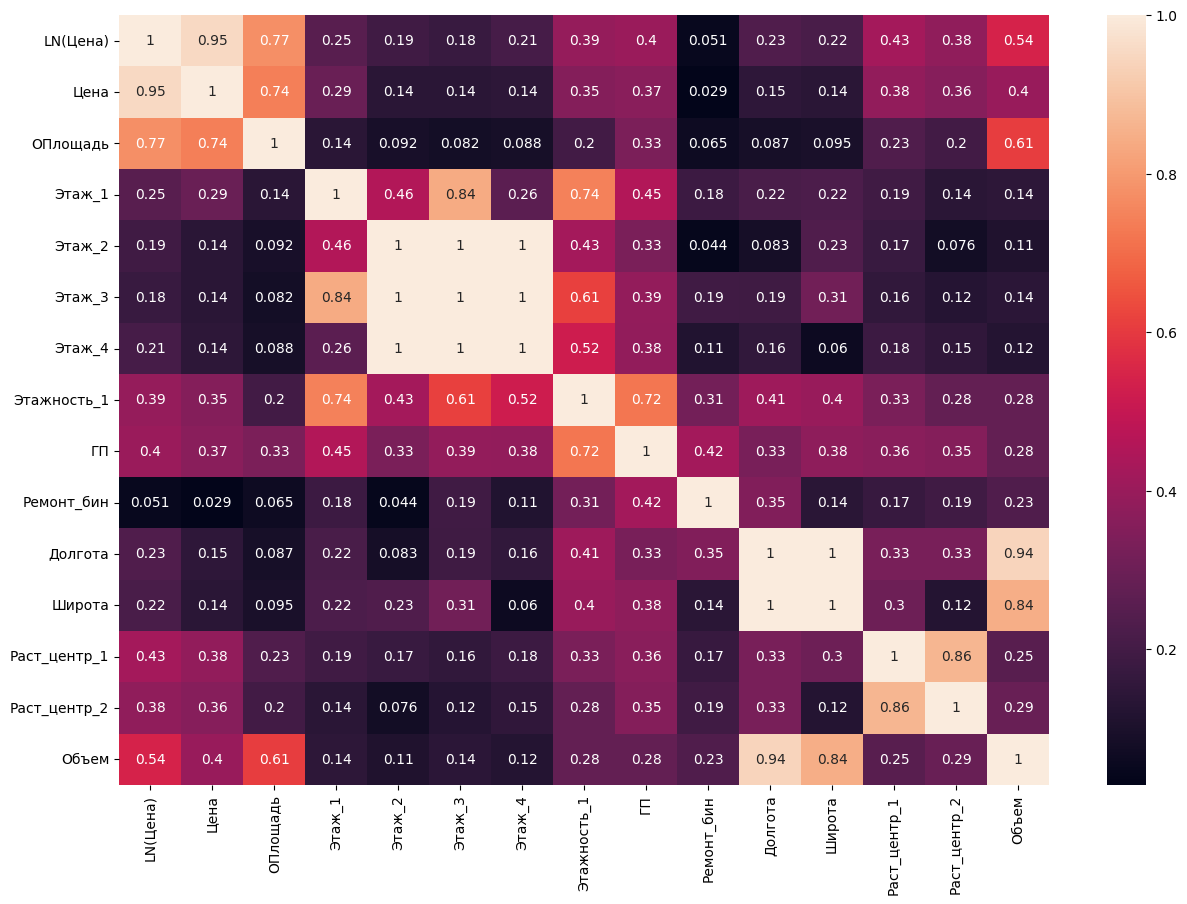

In [42]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = df[['LN(Цена)', 'Цена', 'ОПлощадь', 'Этаж_1', 'Этаж_2', 'Этаж_3', 'Этаж_4', 'Этажность_1', 'ГП', 'Ремонт_бин', 
                    'Долгота', 'Широта', 'Раст_центр_1', 'Раст_центр_2', 'Объем']].phik_matrix()
plt.figure(figsize = (15, 10))
sns.heatmap(phik_overview, annot = True)

In [17]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['Этаж_2']]).toarray())

enc_df.columns = enc.get_feature_names_out() #см ниже
#enc_df
df = df.join(enc_df)
df

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этажность_1,ГП,Ремонт_перв,...,Этаж_3_более_25,Этаж_3_первый,Этаж_3_последний,Этаж_3_этажи_11-25,Этаж_3_этажи_2-5,Этаж_3_этажи_6-10,Ремонт_бин_enc,Этаж_2_первый,Этаж_2_последний,Этаж_2_средний
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,26,2009,стандартный,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,26,2009,стандартный,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,26,2009,стандартный,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,26,2009,стандартный,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,26,2009,стандартный,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,24,2022,предчистовая,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,1.0
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,17,2023,предчистовая,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,1.0,0.0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,24,2022,предчистовая,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,1.0
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,24,2022,предчистовая,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,0.0,1.0


In [248]:
encoder = LabelEncoder()

df['Ремонт_бин_enc'] = encoder.fit_transform(df[['Ремонт_бин']])
df['Этаж_4_enc'] = encoder.fit_transform(df[['Этаж_4']])
df

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем,Ремонт_бин_enc,Этаж_4_enc
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,первый_последний,17,2023,предчистовая,требует_ремонта,39.043307,45.078162,6738.601246,от_5000_до_10000,от_28_до_43,3851,1,0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1


In [249]:
df.columns

Index(['LN(Цена)', 'Цена', 'Город', 'ОПлощадь', 'Этаж_1', 'Этаж_2', 'Этаж_3',
       'Этаж_4', 'Этажность_1', 'ГП', 'Ремонт_перв', 'Ремонт_бин', 'Долгота',
       'Широта', 'Раст_центр_1', 'Раст_центр_2', 'S_инт', 'Объем',
       'Ремонт_бин_enc', 'Этаж_4_enc'],
      dtype='object')

In [250]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X = df[['ОПлощадь', 'Этаж_4_enc', 'Этажность_1', 'ГП', 'Ремонт_бин_enc', 
        'Долгота', 'Широта', 'Раст_центр_1', 'Объем'
       ]]

Y = df['LN(Цена)'] #'Цена' LN(Цена)

In [251]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34875 entries, 0 to 34874
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ОПлощадь        34875 non-null  float64
 1   Этаж_4_enc      34875 non-null  int32  
 2   Этажность_1     34875 non-null  int64  
 3   ГП              34875 non-null  int64  
 4   Ремонт_бин_enc  34875 non-null  int32  
 5   Долгота         34875 non-null  float64
 6   Широта          34875 non-null  float64
 7   Раст_центр_1    34875 non-null  float64
 8   Объем           34875 non-null  int64  
dtypes: float64(4), int32(2), int64(3)
memory usage: 2.1 MB


In [252]:
# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [253]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

                            OLS Regression Results                            
Dep. Variable:               LN(Цена)   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     9040.
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:08:22   Log-Likelihood:                -593.04
No. Observations:               27900   AIC:                             1206.
Df Residuals:                   27890   BIC:                             1288.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7416      0.001   1.06e+04      0.0

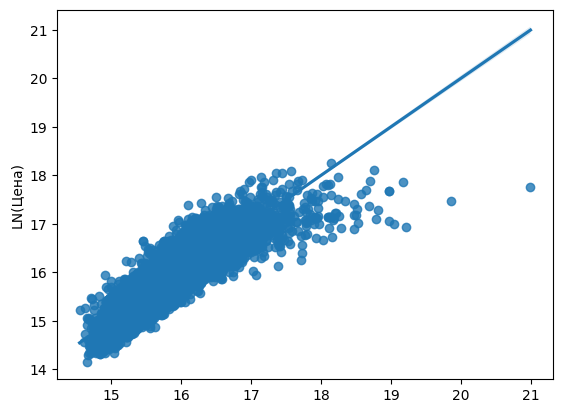

In [254]:
X = sm.add_constant(X_train_sc) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())
#r = results.predict(X)
#r = np.array(results)

# Строим график
sns.regplot(x = results.fittedvalues.copy().values, y = Y_train)
plt.show()

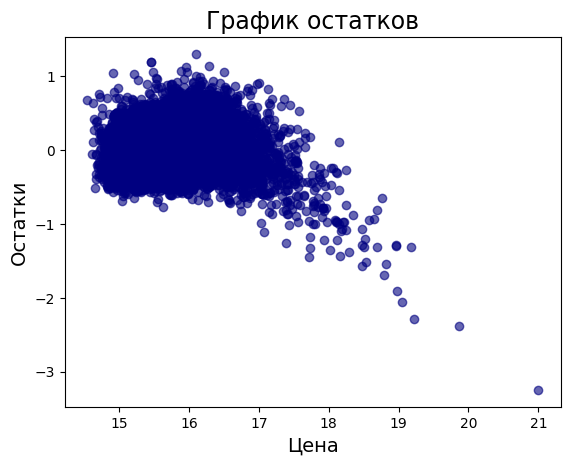

In [217]:
# Строим график остатков обучающей выборки
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)
plt.xlabel('Цена', fontsize = 14)
plt.ylabel('Остатки', fontsize = 14)
plt.title('График остатков', fontsize = 17)
plt.show()

C:\Users\skapr\AppData\Local\Temp\ipykernel_13928\681464043.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, color = 'navy')


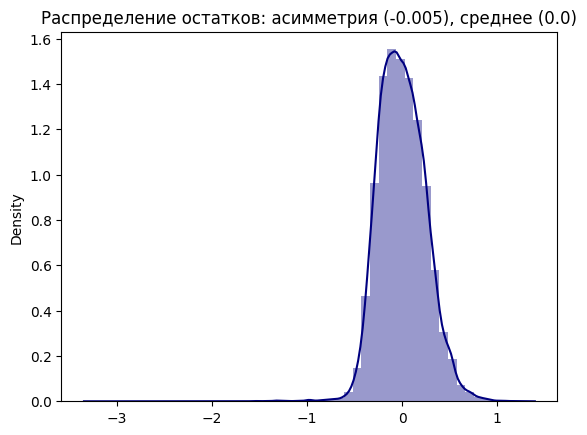

In [218]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean=round(results.resid.mean(), 3)
resid_skew=round(results.resid.skew(), 3)

sns.distplot(results.resid, color = 'navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

BIC - информационный критерий. Похож на AIC, но имеет более высокий штраф для моделей с большим количеством параметров. Чем меньше значение, тем лучше.

Omnibus - тест на асимметрию и эксцесс остатков. Мы надеемся увидеть значение, близкое к нулю, которое указывало бы на нормальность. The Prob (Omnibus) выполняет статистический тест, показывающий вероятность того, что остатки нормально распределены. Мы надеемся увидеть здесь что-то близкое к 1. В случае если Omnibus относительно низок, а Prob (Omnibus) относительно высок, остатки в целом нормальны, но не идеальны. Подход с линейной регрессией, вероятно, будет лучше, чем случайное угадывание, но, вероятно, хуже нелинейных подходов.

Skew - мера симметрии данных. Мы хотим видеть что-то близкое к нулю, это указывает на то, что остаточное распределение нормально.

Kurtosis - это мера «пиковости» или кривизны данных. Более высокие пики приводят к большему куртозу. Большой куртоз можно интерпретировать как более плотную кластеризацию остатков около нуля, что подразумевает лучшую модель с небольшим количеством выбросов (т.е. чем больше, тем лучше).

Cond. No. - значения больше 20 вызывают подозрения в мультиколлинеарности. Чаще всего сложно пройти данный тест. Чем меньше, тем лучше.

R2 - насколько переменные хорошо объясняют разброс оценок. Максимальное значение – 1. Но при значениях более 0,9 надо крайне внимательно проверить на эффект мультиколлинеарности. Adj. R-squared - это нормированный R2, который используется для сравнения моделей регрессии (как AIC и BIC).

Durbin-Watson - тест на наличие автокорреляции в остатках. В идеале значение должно стремиться к 2 (минимальное значение – 0, максимальное – 4). Значения меньше 0,8 однозначно указывают на циклические колебания в остатках. Эмпирически считается, что статистика лежит в нормальных пределах, если больше 1,5 и меньше 2,5.

Jarque-Bera (JB) - тест на нормальность остатков. Используется на больших наборах данных, более 2000. По своей сути аналогичен Omnibus. Если Prob(JB)>0.05, то считается, что остатки распределены нормально.

MAE на обучении: 1783175.3585
RMSE на обучении: 8967882.2485
MAPE на обучении: 0.1997
MAE на тесте: 1726016.8759
RMSE на тесте: 5057430.9975
MAPE на тесте: 0.197


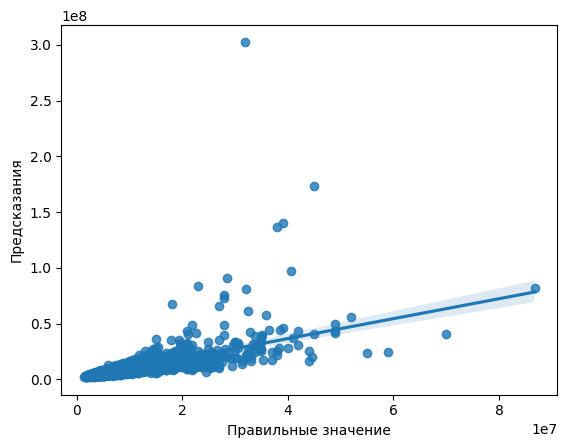

In [255]:
model2 = LinearRegression()
model2.fit(X_train_sc, Y_train)

# X = sm.add_constant(X)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

#pred_1 = np.exp(model2.predict(X))

pred_train = np.exp(model2.predict(X_train_sc))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
#print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(model2.predict(X_test_sc))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
#print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [256]:
features = { 
             'name': ['const',
             'ОПлощадь',
             'Этаж_4_enc',
             'Этажность_1',
             'ГП',
             'Ремонт_бин_enc',
             'Долгота',
             'Широта',
             'Раст_центр_1',
             'Объем']}
features = pd.DataFrame(features)
features['coeff'] = results.params.values
features

,name,coeff
0,const,15.741589
1,ОПлощадь,0.373754
2,Этаж_4_enc,0.017527
3,Этажность_1,0.009594
4,ГП,0.121616
5,Ремонт_бин_enc,-0.026329
6,Долгота,0.124766
7,Широта,0.051905
8,Раст_центр_1,-0.115634
9,Объем,0.056715


In [257]:
train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns, index = X_train.index)
test_sc = pd.DataFrame(X_test_sc, columns = X_test.columns, index = X_test.index)

In [258]:
combined_scaled = pd.concat([train_sc, test_sc])
combined_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем
32901,0.162388,0.50861,0.341934,0.871526,-0.675677,-0.673906,-0.903439,0.550574,1.587764
25737,-0.555384,0.50861,1.583001,0.688605,-0.675677,-0.670914,-0.916325,-1.160876,0.875498
15391,-0.343786,0.50861,-0.623341,0.048382,-0.675677,-0.323198,0.914207,-0.286547,0.435924
5096,0.564838,0.50861,2.686172,0.871526,1.479998,0.066369,1.085924,-0.942069,-1.039738
8969,0.220474,0.50861,-1.174926,-1.232064,-0.675677,2.499315,-1.220337,2.764459,-0.644192
...,...,...,...,...,...,...,...,...,...
9159,0.805479,0.50861,-0.485445,-0.317459,-0.675677,2.496212,-1.237382,-0.685298,-1.271242
16948,-0.136338,0.50861,-0.623341,-0.134539,-0.675677,-0.322163,0.912132,0.212574,0.435924
3509,-1.094750,0.50861,-1.174926,-1.689366,-0.675677,0.064291,1.086955,-1.057802,-1.442385
8197,0.888458,0.50861,1.169312,0.871526,1.479998,2.502519,-1.208160,5.685003,-1.271242


In [259]:
combined_scaled['original_index'] = combined_scaled.index

combined_scaled = combined_scaled.reset_index(drop = True)
combined_scaled = combined_scaled.sort_values('original_index').reset_index(drop = True)
combined_scaled = combined_scaled.drop('original_index', axis = 1)
combined_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем
0,0.701754,0.508610,1.720897,0.231303,-0.675677,0.062562,1.085067,-0.200723,-1.039738
1,0.701754,0.508610,1.720897,0.231303,-0.675677,0.062562,1.085067,-0.200723,-1.039738
2,0.701754,0.508610,1.720897,0.231303,-0.675677,0.062562,1.085067,-0.200723,-1.039738
3,0.701754,0.508610,1.720897,0.231303,-0.675677,0.062562,1.085067,-0.200723,-1.039738
4,0.689307,0.508610,1.720897,0.231303,-0.675677,0.062562,1.085067,-0.200723,-1.039738
...,...,...,...,...,...,...,...,...,...
34870,-0.684002,0.508610,1.445104,0.825796,1.479998,-0.669296,-0.906902,-0.024554,0.875498
34871,-0.555384,-1.966142,0.479830,0.871526,1.479998,-0.669138,-0.907060,0.032467,0.875498
34872,-0.696449,0.508610,1.445104,0.825796,1.479998,-0.669296,-0.906902,-0.024554,0.875498
34873,-0.696449,0.508610,1.445104,0.825796,1.479998,-0.669296,-0.906902,-0.024554,0.875498


In [260]:
pred_1 = np.exp(model2.predict(combined_scaled))
pred_1

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([9855949.54180055, 9855949.54180055, 9855949.54180055, ...,
       5322449.87721882, 5322449.87721882, 5330709.77937303])

In [262]:
#Сохраняем в Excel
writer = pd.ExcelWriter('All_прогноз.xlsx')
pd.DataFrame(pred_1).to_excel(writer, 'прогноз')
writer._save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_13928\4109821760.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(pred_1).to_excel(writer, 'прогноз')


# Полиномиальная регрессия 1

In [3]:
df = pd.read_excel('All.xlsx', sheet_name = 0)
df.head(5)

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154


In [4]:
encoder = LabelEncoder()

df['Ремонт_бин_enc'] = encoder.fit_transform(df[['Ремонт_бин']])
df['Этаж_4_enc'] = encoder.fit_transform(df[['Этаж_4']])
df

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем,Ремонт_бин_enc,Этаж_4_enc
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,первый_последний,17,2023,предчистовая,требует_ремонта,39.043307,45.078162,6738.601246,от_5000_до_10000,от_28_до_43,3851,1,0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1


In [5]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X_cyti = df[['Город']]

X = df[['ОПлощадь', 'Этаж_4_enc', 'Этажность_1', 'ГП', 'Ремонт_бин_enc', 
        'Долгота', 'Широта', 'Раст_центр_1', 'Объем'
       ]]

Y = df['LN(Цена)'] #'Цена' LN(Цена)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34875 entries, 0 to 34874
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ОПлощадь        34875 non-null  float64
 1   Этаж_4_enc      34875 non-null  int32  
 2   Этажность_1     34875 non-null  int64  
 3   ГП              34875 non-null  int64  
 4   Ремонт_бин_enc  34875 non-null  int32  
 5   Долгота         34875 non-null  float64
 6   Широта          34875 non-null  float64
 7   Раст_центр_1    34875 non-null  float64
 8   Объем           34875 non-null  int64  
dtypes: float64(4), int32(2), int64(3)
memory usage: 2.1 MB


In [7]:
# Создаем полиномиальные признаки
degree = 2

poly = PolynomialFeatures(degree = degree, include_bias = False) #include_bias=False
X_poly = poly.fit_transform(X)

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Создаем новые DF для масштабированных признаков
X_scaled = pd.DataFrame(X_scaled, columns = poly.get_feature_names_out(X.columns))

X_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,...,Долгота^2,Долгота Широта,Долгота Раст_центр_1,Долгота Объем,Широта^2,Широта Раст_центр_1,Широта Объем,Раст_центр_1^2,Раст_центр_1 Объем,Объем^2
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.370360,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.523751,...,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.524149,0.795987
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,-0.463512,...,-0.544630,-0.926806,-0.356934,0.292151,-0.919112,-0.153366,0.634646,-0.156076,0.582609,0.795987
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,...,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.524149,0.795987
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,...,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.524149,0.795987


Используем PolynomialFeatures для создания полиномиальных и перекрестных признаков. Степень полинома контролируется параметром degree. include_bias=False убирает столбец из 1, так как OLS регрессия добавит столбец из 1 для константы (intercept).

In [8]:
# Делим имеющуюся выборку на обучающую и тестовую
random_state = 42

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = random_state)
vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = random_state)
kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = random_state)
kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = random_state)

In [9]:
combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
combined_train

,Город
1514,Екатеринбург
265,Екатеринбург
0,Екатеринбург
1451,Екатеринбург
3570,Екатеринбург
...,...
18199,Казань
17656,Казань
17855,Казань
13325,Казань


In [10]:
X_train, X_test = X_scaled.loc[combined_train.index], X_scaled.loc[combined_test.index]
Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]

                            OLS Regression Results                            
Dep. Variable:               LN(Цена)   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     3635.
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:54:19   Log-Likelihood:                 8963.1
No. Observations:               27898   AIC:                        -1.782e+04
Df Residuals:                   27845   BIC:                        -1.738e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

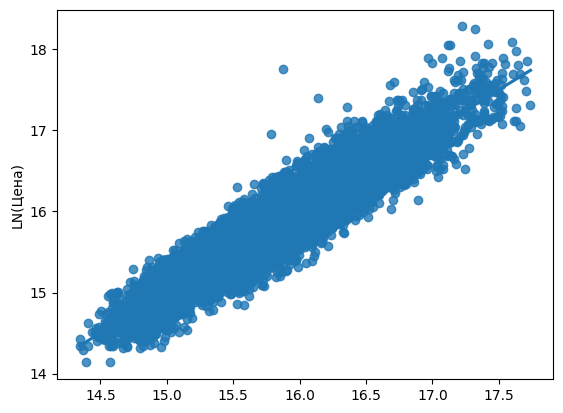

In [11]:
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())
#r = results.predict(X)
#r = np.array(results)

# Строим график
sns.regplot(x = results.fittedvalues.copy().values, y = Y_train)
plt.show()

Исключение всех незначимых факторов сразу может показаться привлекательным, но это не рекомендуется. Это может привести к пропуску важных взаимодействий между переменными или к излишней потере информации.
Лучшим подходом является последовательное исключение по одному фактору за раз. После каждого удаления пересчитывайте модель и анализируйте results.summary(). Этот метод позволяет отслеживать, как изменение набора предикторов влияет на остальную часть модели и на ее качество в целом.
Начните с исключения предиктора с наибольшим p-значением. P-значение показывает вероятность того, что данный коэффициент в регрессии на самом деле равен нулю (то есть фактор не влияет на целевую переменную), если нулевая гипотеза верна. Чем выше p-значение, тем менее значим фактор. Обычно порогом значимости считается 0.05 (5%), но это зависит от конкретной задачи.
Не забывайте о контексте вашей задачи. Иногда фактор может быть статистически незначим, но иметь важное теоретическое значение. В таком случае, его можно оставить в модели, но стоит отметить его p-значение.

Если коэффициент значим, но имеет большой разброс, это может указывать на несколько вещей:
  * Мультиколлинеарность: Возможно, он коррелирует с другими предикторами, и небольшое изменение в выборке приводит к большим колебаниям его значения.
  * Недостаточный размер выборки: Если данных мало, то даже значимые коэффициенты могут быть нестабильными.
  * Сильное влияние выбросов: Выбросы могут сильно влиять на значения коэффициентов.

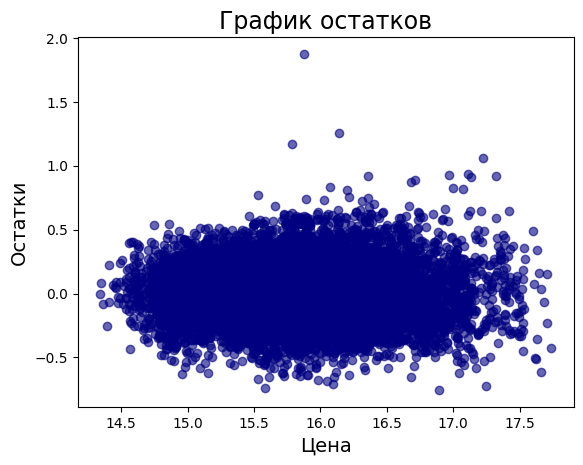

In [12]:
# Строим график остатков обучающей выборки
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)
plt.xlabel('Цена', fontsize = 14)
plt.ylabel('Остатки', fontsize = 14)
plt.title('График остатков', fontsize = 17)
plt.show()

C:\Users\skapr\AppData\Local\Temp\ipykernel_15356\681464043.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, color = 'navy')


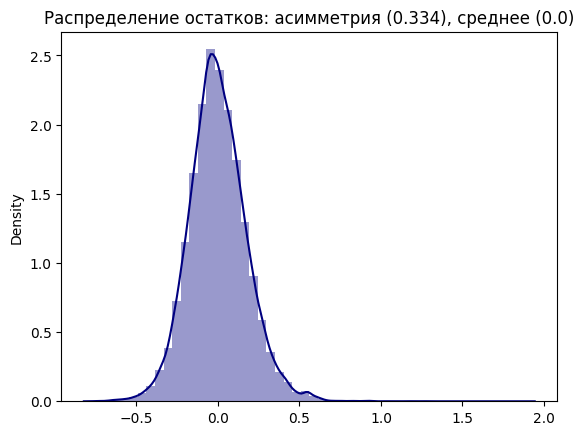

In [13]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean=round(results.resid.mean(), 3)
resid_skew=round(results.resid.skew(), 3)

sns.distplot(results.resid, color = 'navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

BIC - информационный критерий. Похож на AIC, но имеет более высокий штраф для моделей с большим количеством параметров. Чем меньше значение, тем лучше.

Omnibus - тест на асимметрию и эксцесс остатков. Мы надеемся увидеть значение, близкое к нулю, которое указывало бы на нормальность. The Prob (Omnibus) выполняет статистический тест, показывающий вероятность того, что остатки нормально распределены. Мы надеемся увидеть здесь что-то близкое к 1. В случае если Omnibus относительно низок, а Prob (Omnibus) относительно высок, остатки в целом нормальны, но не идеальны. Подход с линейной регрессией, вероятно, будет лучше, чем случайное угадывание, но, вероятно, хуже нелинейных подходов.

Skew - мера симметрии данных. Мы хотим видеть что-то близкое к нулю, это указывает на то, что остаточное распределение нормально.

Kurtosis - это мера «пиковости» или кривизны данных. Более высокие пики приводят к большему куртозу. Большой куртоз можно интерпретировать как более плотную кластеризацию остатков около нуля, что подразумевает лучшую модель с небольшим количеством выбросов (т.е. чем больше, тем лучше).

Cond. No. - значения больше 20 вызывают подозрения в мультиколлинеарности. Чаще всего сложно пройти данный тест. Чем меньше, тем лучше.

R2 - насколько переменные хорошо объясняют разброс оценок. Максимальное значение – 1. Но при значениях более 0,9 надо крайне внимательно проверить на эффект мультиколлинеарности. Adj. R-squared - это нормированный R2, который используется для сравнения моделей регрессии (как AIC и BIC).

Durbin-Watson - тест на наличие автокорреляции в остатках. В идеале значение должно стремиться к 2 (минимальное значение – 0, максимальное – 4). Значения меньше 0,8 однозначно указывают на циклические колебания в остатках. Эмпирически считается, что статистика лежит в нормальных пределах, если больше 1,5 и меньше 2,5.

Jarque-Bera (JB) - тест на нормальность остатков. Используется на больших наборах данных, более 2000. По своей сути аналогичен Omnibus. Если Prob(JB)>0.05, то считается, что остатки распределены нормально.

MAE на обучении: 1142928.4457
RMSE на обучении: 2033785.0231
MAPE на обучении: 0.136
R2 на обучении: 0.8266
MAE на тесте: 1137708.224
RMSE на тесте: 2018643.0469
MAPE на тесте: 0.1354
R2 на тесте: 0.8262


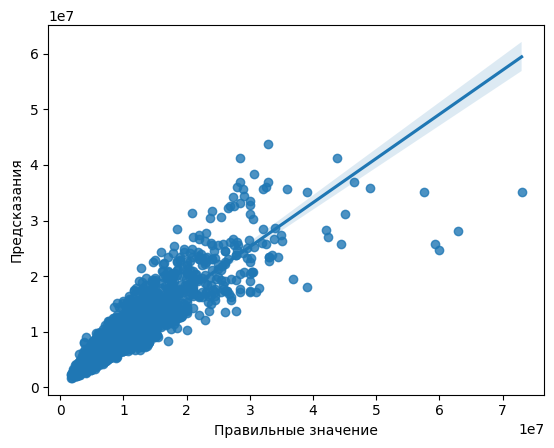

In [14]:
model2 = LinearRegression()
model2.fit(X_train, Y_train)

# X = sm.add_constant(X)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

#pred_1 = np.exp(model2.predict(X))

pred_train = np.exp(model2.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(model2.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [15]:
X_train.columns.values

array(['ОПлощадь', 'Этаж_4_enc', 'Этажность_1', 'ГП', 'Ремонт_бин_enc',
       'Долгота', 'Широта', 'Раст_центр_1', 'Объем', 'ОПлощадь^2',
       'ОПлощадь Этаж_4_enc', 'ОПлощадь Этажность_1', 'ОПлощадь ГП',
       'ОПлощадь Ремонт_бин_enc', 'ОПлощадь Долгота', 'ОПлощадь Широта',
       'ОПлощадь Раст_центр_1', 'ОПлощадь Объем', 'Этаж_4_enc^2',
       'Этаж_4_enc Этажность_1', 'Этаж_4_enc ГП',
       'Этаж_4_enc Ремонт_бин_enc', 'Этаж_4_enc Долгота',
       'Этаж_4_enc Широта', 'Этаж_4_enc Раст_центр_1', 'Этаж_4_enc Объем',
       'Этажность_1^2', 'Этажность_1 ГП', 'Этажность_1 Ремонт_бин_enc',
       'Этажность_1 Долгота', 'Этажность_1 Широта',
       'Этажность_1 Раст_центр_1', 'Этажность_1 Объем', 'ГП^2',
       'ГП Ремонт_бин_enc', 'ГП Долгота', 'ГП Широта', 'ГП Раст_центр_1',
       'ГП Объем', 'Ремонт_бин_enc^2', 'Ремонт_бин_enc Долгота',
       'Ремонт_бин_enc Широта', 'Ремонт_бин_enc Раст_центр_1',
       'Ремонт_бин_enc Объем', 'Долгота^2', 'Долгота Широта',
       'Долгота Ра

In [16]:
features = { 
             'name': ['const'] + list(X_train.columns)}
features = pd.DataFrame(features)
features['coeff'] = results.params.values
features

,name,coeff
0,const,15.741593
1,ОПлощадь,0.383083
2,Этаж_4_enc,-0.051995
3,Этажность_1,2.943636
4,ГП,-11.674297
5,Ремонт_бин_enc,-0.608798
6,Долгота,-15.849834
7,Широта,26.012090
8,Раст_центр_1,1.990131
9,Объем,1.912848


In [17]:
results.params.values

array([ 1.57415933e+01,  3.83083152e-01, -5.19945871e-02,  2.94363631e+00,
       -1.16742967e+01, -6.08797638e-01, -1.58498336e+01,  2.60120900e+01,
        1.99013132e+00,  1.91284752e+00, -2.13283425e-01,  1.27725188e-02,
       -1.79136122e-03,  3.90910911e-01, -4.92154332e-03, -6.40704554e-02,
       -1.46109380e-01, -4.35669461e-02, -1.80712526e-02, -5.19945871e-02,
       -2.13309056e-02,  5.27277195e-02,  2.13992496e-04,  1.46805446e-02,
        5.52695758e-02, -2.83422361e-03,  6.18241436e-03,  1.09410182e-02,
       -2.54342940e+00, -2.40751562e-02, -8.88112700e-02, -2.83819614e-01,
       -4.14914842e-02,  6.59841382e-03,  1.14013921e+01,  1.07372196e+00,
        1.91548866e+00,  4.38102595e+00, -1.76191223e+00, -1.88283388e+00,
       -6.08797638e-01, -1.66303705e-02,  1.36356116e-01, -1.84474648e-03,
        4.54468673e-03,  6.97038615e+00,  7.64795328e+00, -5.86335230e-02,
        1.28796325e-02, -3.14037433e+01, -4.09893170e-01,  6.45085961e-02,
        1.25918137e-01, -

In [318]:
alpha_r = 1
alpha_l = 0.0001

# Ridge регрессия
ridge_model = Ridge(alpha = alpha_r)
ridge_model.fit(X_train, Y_train)

# Lasso регрессия
lasso_model = Lasso(alpha = alpha_l)
lasso_model.fit(X_train, Y_train)

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+02, tolerance: 6.691e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001)

MAE на обучении: 1204897.1061
RMSE на обучении: 2139576.0406
MAPE на обучении: 0.1429
R2 на обучении: 0.8081
MAE на тесте: 1200066.1454
RMSE на тесте: 2135579.5752
MAPE на тесте: 0.1419
R2 на тесте: 0.8055


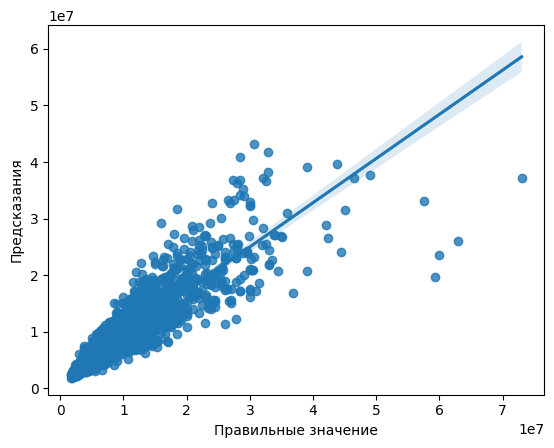

In [319]:
model2 = lasso_model

pred_train = np.exp(model2.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(model2.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# Отобранные фичи

In [18]:
df = pd.read_excel('All.xlsx', sheet_name = 0)
df.head(5)

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154


In [19]:
encoder = LabelEncoder()

df['Ремонт_бин_enc'] = encoder.fit_transform(df[['Ремонт_бин']])
df['Этаж_4_enc'] = encoder.fit_transform(df[['Этаж_4']])
df

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем,Ремонт_бин_enc,Этаж_4_enc
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,первый_последний,17,2023,предчистовая,требует_ремонта,39.043307,45.078162,6738.601246,от_5000_до_10000,от_28_до_43,3851,1,0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1


In [20]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X_cyti = df[['Город']]

X = df[['ОПлощадь', 'Этаж_4_enc', 'Этажность_1', 'ГП', 'Ремонт_бин_enc', 
        'Долгота', 'Широта', 'Раст_центр_1', 'Объем'
       ]]

Y = df['LN(Цена)'] #'Цена' LN(Цена)

In [21]:
# Создаем полиномиальные признаки
degree = 2

poly = PolynomialFeatures(degree = degree, include_bias = False) #include_bias=False
X_poly = poly.fit_transform(X)

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Создаем новые DF для масштабированных признаков
X_scaled = pd.DataFrame(X_scaled, columns = poly.get_feature_names_out(X.columns))

X_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,...,Долгота^2,Долгота Широта,Долгота Раст_центр_1,Долгота Объем,Широта^2,Широта Раст_центр_1,Широта Объем,Раст_центр_1^2,Раст_центр_1 Объем,Объем^2
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.370360,...,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.771343,-0.993685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.523751,...,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.524149,0.795987
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,-0.463512,...,-0.544630,-0.926806,-0.356934,0.292151,-0.919112,-0.153366,0.634646,-0.156076,0.582609,0.795987
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,...,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.524149,0.795987
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,...,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.524149,0.795987


In [22]:
X_scaled_selected = X_scaled[['ОПлощадь', 
                              #'Этаж_4_enc', 
                              'Этажность_1', 
                              'ГП', 
                              'Ремонт_бин_enc',
                              'Долгота', 
                              'Широта', 
                              'Раст_центр_1', 
                              'Объем', 
                              'ОПлощадь^2',
                              'ОПлощадь Этаж_4_enc', 
                              #'ОПлощадь Этажность_1', 
                              'ОПлощадь ГП',
                              #'ОПлощадь Ремонт_бин_enc', 
                              'ОПлощадь Долгота', 
                              'ОПлощадь Широта',
                              'ОПлощадь Раст_центр_1', 
                              'ОПлощадь Объем', 
                              #'Этаж_4_enc^2',
                              'Этаж_4_enc Этажность_1', 
                              #'Этаж_4_enc ГП',
                              #'Этаж_4_enc Ремонт_бин_enc', 
                              #'Этаж_4_enc Долгота',
                              'Этаж_4_enc Широта', 
                              #'Этаж_4_enc Раст_центр_1', 
                              #'Этаж_4_enc Объем',
                              #'Этажность_1^2', 
                              'Этажность_1 ГП', 
                              'Этажность_1 Ремонт_бин_enc',
                              'Этажность_1 Долгота', 
                              'Этажность_1 Широта',
                              'Этажность_1 Раст_центр_1', 
                              #'Этажность_1 Объем', 
                              'ГП^2',
                              'ГП Ремонт_бин_enc', 
                              'ГП Долгота', 
                              'ГП Широта', 
                              'ГП Раст_центр_1',
                              'ГП Объем', 
                              'Ремонт_бин_enc^2', 
                              'Ремонт_бин_enc Долгота',
                              'Ремонт_бин_enc Широта',
                              #'Ремонт_бин_enc Раст_центр_1',
                              #'Ремонт_бин_enc Объем', 
                              'Долгота^2',
                              'Долгота Широта',
                              'Долгота Раст_центр_1', 
                              'Долгота Объем', 
                              'Широта^2',
                              'Широта Раст_центр_1', 
                              'Широта Объем', 
                              'Раст_центр_1^2',
                              #'Раст_центр_1 Объем', 
                              'Объем^2'
                             ]]

In [23]:
X_scaled_selected

,ОПлощадь,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этаж_4_enc,...,Ремонт_бин_enc Широта,Долгота^2,Долгота Широта,Долгота Раст_центр_1,Долгота Объем,Широта^2,Широта Раст_центр_1,Широта Объем,Раст_центр_1^2,Объем^2
0,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
1,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
2,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
3,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
4,0.687708,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.370360,0.876300,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.523751,-0.202165,...,1.307595,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.795987
34871,-0.555364,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,-0.463512,-1.404442,...,1.307555,-0.544630,-0.926806,-0.356934,0.292151,-0.919112,-0.153366,0.634646,-0.156076,0.795987
34872,-0.696245,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,-0.211939,...,1.307595,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.795987
34873,-0.696245,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,-0.211939,...,1.307595,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.795987


In [24]:
# Делим имеющуюся выборку на обучающую и тестовую
random_state = 42

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = random_state)
vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = random_state)
kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = random_state)
kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = random_state)

In [25]:
combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
combined_train

,Город
1514,Екатеринбург
265,Екатеринбург
0,Екатеринбург
1451,Екатеринбург
3570,Екатеринбург
...,...
18199,Казань
17656,Казань
17855,Казань
13325,Казань


In [26]:
X_train, X_test = X_scaled_selected.loc[combined_train.index], X_scaled_selected.loc[combined_test.index]
Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]

                            OLS Regression Results                            
Dep. Variable:               LN(Цена)   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     4843.
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:55:13   Log-Likelihood:                 8947.4
No. Observations:               27898   AIC:                        -1.781e+04
Df Residuals:                   27858   BIC:                        -1.749e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

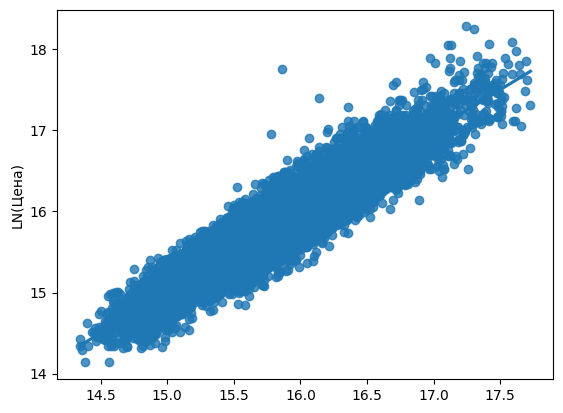

In [27]:
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())
#r = results.predict(X)
#r = np.array(results)

# Строим график
sns.regplot(x = results.fittedvalues.copy().values, y = Y_train)
plt.show()

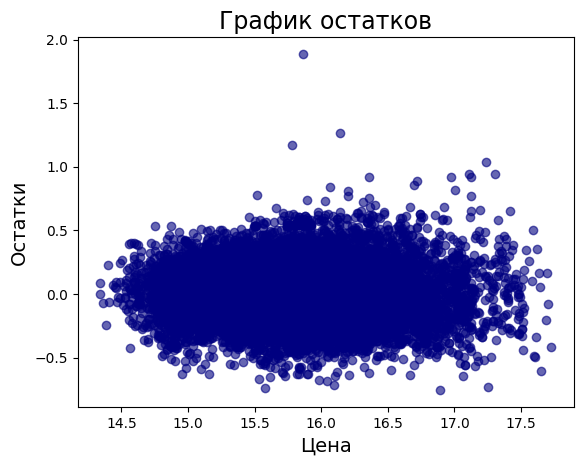

In [28]:
# Строим график остатков обучающей выборки
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)
plt.xlabel('Цена', fontsize = 14)
plt.ylabel('Остатки', fontsize = 14)
plt.title('График остатков', fontsize = 17)
plt.show()

C:\Users\skapr\AppData\Local\Temp\ipykernel_15356\2026489784.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, color = 'navy')


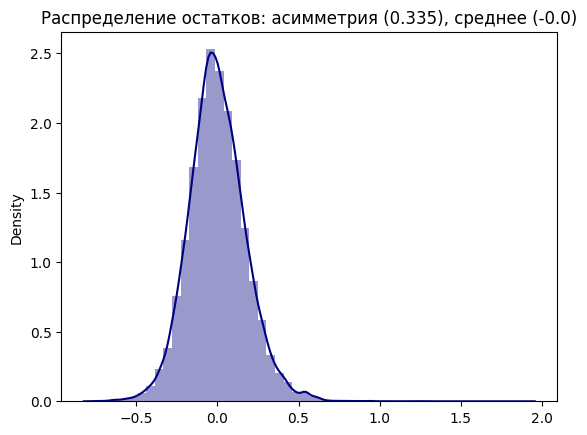

In [29]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

sns.distplot(results.resid, color = 'navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

BIC - информационный критерий. Похож на AIC, но имеет более высокий штраф для моделей с большим количеством параметров. Чем меньше значение, тем лучше.

Omnibus - тест на асимметрию и эксцесс остатков. Мы надеемся увидеть значение, близкое к нулю, которое указывало бы на нормальность. The Prob (Omnibus) выполняет статистический тест, показывающий вероятность того, что остатки нормально распределены. Мы надеемся увидеть здесь что-то близкое к 1. В случае если Omnibus относительно низок, а Prob (Omnibus) относительно высок, остатки в целом нормальны, но не идеальны. Подход с линейной регрессией, вероятно, будет лучше, чем случайное угадывание, но, вероятно, хуже нелинейных подходов.

Skew - мера симметрии данных. Мы хотим видеть что-то близкое к нулю, это указывает на то, что остаточное распределение нормально.

Kurtosis - это мера «пиковости» или кривизны данных. Более высокие пики приводят к большему куртозу. Большой куртоз можно интерпретировать как более плотную кластеризацию остатков около нуля, что подразумевает лучшую модель с небольшим количеством выбросов (т.е. чем больше, тем лучше).

Cond. No. - значения больше 20 вызывают подозрения в мультиколлинеарности. Чаще всего сложно пройти данный тест. Чем меньше, тем лучше.

R2 - насколько переменные хорошо объясняют разброс оценок. Максимальное значение – 1. Но при значениях более 0,9 надо крайне внимательно проверить на эффект мультиколлинеарности. Adj. R-squared - это нормированный R2, который используется для сравнения моделей регрессии (как AIC и BIC).

Durbin-Watson - тест на наличие автокорреляции в остатках. В идеале значение должно стремиться к 2 (минимальное значение – 0, максимальное – 4). Значения меньше 0,8 однозначно указывают на циклические колебания в остатках. Эмпирически считается, что статистика лежит в нормальных пределах, если больше 1,5 и меньше 2,5.

Jarque-Bera (JB) - тест на нормальность остатков. Используется на больших наборах данных, более 2000. По своей сути аналогичен Omnibus. Если Prob(JB)>0.05, то считается, что остатки распределены нормально.

MAE на обучении: 1143586.2394
RMSE на обучении: 2033465.4838
MAPE на обучении: 0.1361
R2 на обучении: 0.8267
MAE на тесте: 1139913.4529
RMSE на тесте: 2023009.2386
MAPE на тесте: 0.1356
R2 на тесте: 0.8254


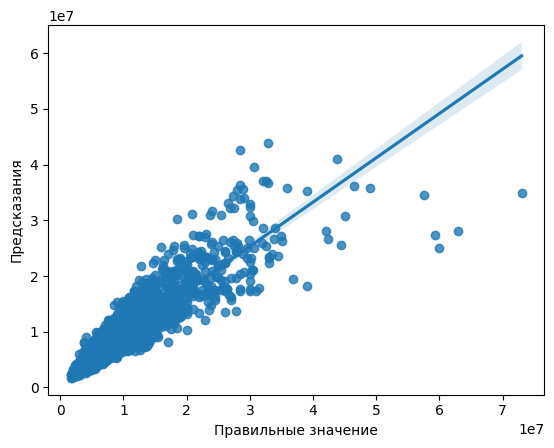

In [30]:
model2 = LinearRegression()
model2.fit(X_train, Y_train)

# X = sm.add_constant(X)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

#pred_1 = np.exp(model2.predict(X))

pred_train = np.exp(model2.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(model2.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [31]:
combined_X = pd.concat([X_train, X_test])
combined_X

,ОПлощадь,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этаж_4_enc,...,Ремонт_бин_enc Широта,Долгота^2,Долгота Широта,Долгота Раст_центр_1,Долгота Объем,Широта^2,Широта Раст_центр_1,Широта Объем,Раст_центр_1^2,Объем^2
1514,0.741574,1.165252,0.870366,1.477463,0.067656,1.078856,0.398187,-1.039574,0.416777,0.918657,...,1.820984,-0.122221,0.421267,0.319061,-1.078196,1.089834,0.636017,-0.969312,0.098702,-0.993685
265,0.335504,-1.177657,-1.725466,1.477463,0.067476,1.077414,0.563481,0.273875,0.087918,0.599353,...,1.820611,-0.122346,0.420614,0.430501,0.834065,1.088208,0.813797,0.587554,0.229983,0.024592
0,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
1451,-0.141007,-0.626384,0.915907,1.477463,0.062977,1.095186,-0.290614,0.273875,-0.236092,-1.404442,...,1.825204,-0.125480,0.419687,-0.148126,0.827305,1.108261,-0.103699,0.592218,-0.343831,0.024592
3570,-0.161724,0.200525,0.779284,1.477463,0.064719,1.088466,-1.580382,0.273875,-0.248664,0.208369,...,1.823468,-0.124267,0.420096,-1.016670,0.829923,1.100675,-1.496293,0.590454,-0.719042,0.024592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21212,0.894886,-0.626384,0.551580,-0.676836,-0.323455,0.913700,-0.243063,-0.977740,0.553560,-1.404442,...,-0.670580,-0.369164,-0.138366,-0.306728,-1.231095,0.905221,-0.083022,-0.913917,-0.318699,-0.966059
18756,-0.472492,-0.626384,0.870366,1.477463,-0.322314,0.914054,0.317368,0.477147,-0.422071,-0.035996,...,1.778389,-0.368519,-0.136788,0.000787,0.488547,0.905614,0.510742,0.781568,0.038048,0.263101
17082,0.563401,-1.315475,-3.046152,-0.676836,-0.328274,0.915447,-0.737776,-0.977740,0.266505,-1.404442,...,-0.670580,-0.371885,-0.144275,-0.579100,-1.234088,0.907157,-0.606889,-0.913727,-0.540864,-0.966059
19660,-1.487667,-1.177657,-2.135334,-0.676836,-0.324596,0.911352,-0.802858,-1.145475,-0.790428,-1.404442,...,-0.670580,-0.369809,-0.140404,-0.613477,-1.429710,0.902619,-0.676280,-1.109585,-0.563617,-1.036336


In [32]:
combined_X['original_index'] = combined_X.index

combined_X = combined_X.reset_index(drop = True)
combined_X = combined_X.sort_values('original_index').reset_index(drop = True)
combined_X = combined_X.drop('original_index', axis = 1)
combined_X

,ОПлощадь,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этаж_4_enc,...,Ремонт_бин_enc Широта,Долгота^2,Долгота Широта,Долгота Раст_центр_1,Долгота Объем,Широта^2,Широта Раст_центр_1,Широта Объем,Раст_центр_1^2,Объем^2
0,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
1,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
2,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
3,0.700138,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.380996,0.886075,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
4,0.687708,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.370360,0.876300,...,-0.670580,-0.125991,0.415609,-0.086931,-1.081323,1.095997,-0.006894,-0.968761,-0.294803,-0.993685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.523751,-0.202165,...,1.307595,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.795987
34871,-0.555364,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,-0.463512,-1.404442,...,1.307555,-0.544630,-0.926806,-0.356934,0.292151,-0.919112,-0.153366,0.634646,-0.156076,0.795987
34872,-0.696245,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,-0.211939,...,1.307595,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.795987
34873,-0.696245,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,-0.211939,...,1.307595,-0.544701,-0.926944,-0.381827,0.291847,-0.918971,-0.202199,0.634699,-0.191788,0.795987


In [33]:
pred_1 = np.exp(model2.predict(combined_X))
pred_1

array([8468611.90286913, 8468611.90286913, 8468611.90286913, ...,
       5144006.17844606, 5144790.05878613, 5155162.93274277])

In [38]:
#Сохраняем в Excel
writer = pd.ExcelWriter('All_прогноз.xlsx')
pd.DataFrame(pred_1).to_excel(writer, 'прогноз')
writer._save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_10100\4109821760.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(pred_1).to_excel(writer, 'прогноз')


# Полиномиальная регрессия 2

In [208]:
df = pd.read_excel('All.xlsx', sheet_name = 0)
df.head(5)

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154


In [209]:
encoder = LabelEncoder()

df['Ремонт_бин_enc'] = encoder.fit_transform(df[['Ремонт_бин']])
df['Этаж_4_enc'] = encoder.fit_transform(df[['Этаж_4']])
df

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем,Ремонт_бин_enc,Этаж_4_enc
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,первый_последний,17,2023,предчистовая,требует_ремонта,39.043307,45.078162,6738.601246,от_5000_до_10000,от_28_до_43,3851,1,0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1


In [210]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X_cyti = df[['Город']]

X = df[['ОПлощадь', 'Этаж_4_enc', 
        'Этажность_1', 'ГП', 'Ремонт_бин_enc', 
        'Долгота', 'Широта', 'Раст_центр_1', 'Объем'
       ]]

Y = df['LN(Цена)'] #'Цена' LN(Цена)

In [211]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34875 entries, 0 to 34874
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ОПлощадь        34875 non-null  float64
 1   Этаж_4_enc      34875 non-null  int32  
 2   Этажность_1     34875 non-null  int64  
 3   ГП              34875 non-null  int64  
 4   Ремонт_бин_enc  34875 non-null  int32  
 5   Долгота         34875 non-null  float64
 6   Широта          34875 non-null  float64
 7   Раст_центр_1    34875 non-null  float64
 8   Объем           34875 non-null  int64  
dtypes: float64(4), int32(2), int64(3)
memory usage: 2.1 MB


Стандартизация/Нормализация:
Обязательно проводите стандартизацию (StandardScaler) или нормализацию (MinMaxScaler) признаков *перед* созданием полиномиальных признаков. Это уменьшит проблему мультиколлинеарности и поможет стабилизировать коэффициенты.

In [212]:
# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем новые DF для масштабированных признаков
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

X_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294


In [213]:
# Создаем полиномиальные признаки
degree = 3

poly = PolynomialFeatures(degree = degree, include_bias = False) #include_bias=False
X_poly = poly.fit_transform(X_scaled)

X_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names_out(X.columns))
X_poly

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,...,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Широта Раст_центр_1^2,Широта Раст_центр_1 Объем,Широта Объем^2,Раст_центр_1^3,Раст_центр_1^2 Объем,Раст_центр_1 Объем^2,Объем^3
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.472942,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.467602,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,0.308429,...,-0.747718,0.028277,0.722720,-0.001069,-0.027331,-0.698559,0.000040,0.001034,0.026418,0.675205
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205


Используем PolynomialFeatures для создания полиномиальных и перекрестных признаков. Степень полинома контролируется параметром degree. include_bias=False убирает столбец из 1, так как OLS регрессия добавит столбец из 1 для константы (intercept).

In [214]:
X_poly.columns

Index(['ОПлощадь', 'Этаж_4_enc', 'Этажность_1', 'ГП', 'Ремонт_бин_enc',
       'Долгота', 'Широта', 'Раст_центр_1', 'Объем', 'ОПлощадь^2',
       ...
       'Широта^3', 'Широта^2 Раст_центр_1', 'Широта^2 Объем',
       'Широта Раст_центр_1^2', 'Широта Раст_центр_1 Объем', 'Широта Объем^2',
       'Раст_центр_1^3', 'Раст_центр_1^2 Объем', 'Раст_центр_1 Объем^2',
       'Объем^3'],
      dtype='object', length=219)

In [215]:
# Делим имеющуюся выборку на обучающую и тестовую
random_state = 42

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = random_state)
vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = random_state)
kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = random_state)
kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = random_state)

In [216]:
combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
combined_train

,Город
1514,Екатеринбург
265,Екатеринбург
0,Екатеринбург
1451,Екатеринбург
3570,Екатеринбург
...,...
18199,Казань
17656,Казань
17855,Казань
13325,Казань


In [217]:
X_train, X_test = X_poly.loc[combined_train.index], X_poly.loc[combined_test.index]
Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]

                            OLS Regression Results                            
Dep. Variable:               LN(Цена)   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1135.
Date:                Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:18:12   Log-Likelihood:                 11213.
No. Observations:               27898   AIC:                        -2.203e+04
Df Residuals:                   27698   BIC:                        -2.038e+04
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

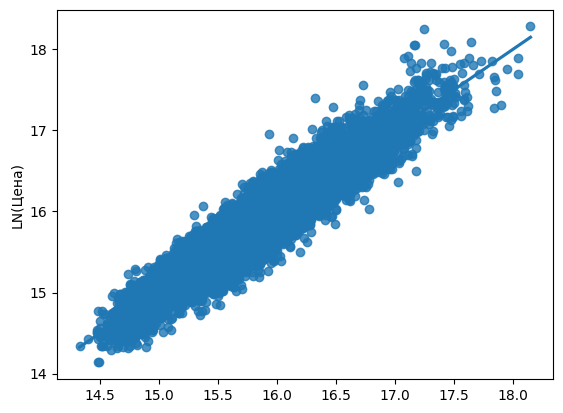

In [218]:
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())
#r = results.predict(X)
#r = np.array(results)

# Строим график
sns.regplot(x = results.fittedvalues.copy().values, y = Y_train)
plt.show()

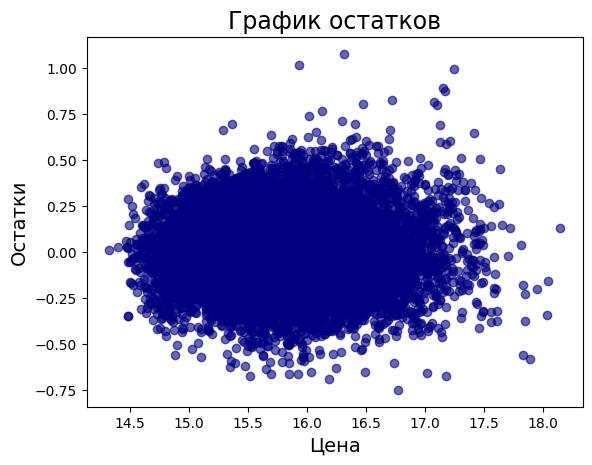

In [219]:
# Строим график остатков обучающей выборки
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)
plt.xlabel('Цена', fontsize = 14)
plt.ylabel('Остатки', fontsize = 14)
plt.title('График остатков', fontsize = 17)
plt.show()

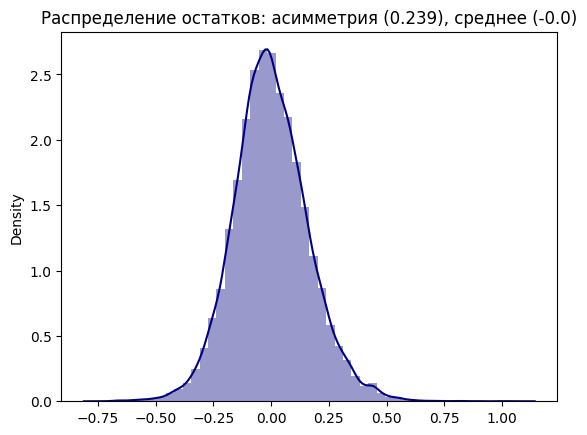

In [220]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean=round(results.resid.mean(), 3)
resid_skew=round(results.resid.skew(), 3)

sns.distplot(results.resid, color = 'navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

BIC - информационный критерий. Похож на AIC, но имеет более высокий штраф для моделей с большим количеством параметров. Чем меньше значение, тем лучше.

Omnibus - тест на асимметрию и эксцесс остатков. Мы надеемся увидеть значение, близкое к нулю, которое указывало бы на нормальность. The Prob (Omnibus) выполняет статистический тест, показывающий вероятность того, что остатки нормально распределены. Мы надеемся увидеть здесь что-то близкое к 1. В случае если Omnibus относительно низок, а Prob (Omnibus) относительно высок, остатки в целом нормальны, но не идеальны. Подход с линейной регрессией, вероятно, будет лучше, чем случайное угадывание, но, вероятно, хуже нелинейных подходов.

Skew - мера симметрии данных. Мы хотим видеть что-то близкое к нулю, это указывает на то, что остаточное распределение нормально.

Kurtosis - это мера «пиковости» или кривизны данных. Более высокие пики приводят к большему куртозу. Большой куртоз можно интерпретировать как более плотную кластеризацию остатков около нуля, что подразумевает лучшую модель с небольшим количеством выбросов (т.е. чем больше, тем лучше).

Cond. No. - значения больше 20 вызывают подозрения в мультиколлинеарности. Чаще всего сложно пройти данный тест. Чем меньше, тем лучше.

R2 - насколько переменные хорошо объясняют разброс оценок. Максимальное значение – 1. Но при значениях более 0,9 надо крайне внимательно проверить на эффект мультиколлинеарности. Adj. R-squared - это нормированный R2, который используется для сравнения моделей регрессии (как AIC и BIC).

Durbin-Watson - тест на наличие автокорреляции в остатках. В идеале значение должно стремиться к 2 (минимальное значение – 0, максимальное – 4). Значения меньше 0,8 однозначно указывают на циклические колебания в остатках. Эмпирически считается, что статистика лежит в нормальных пределах, если больше 1,5 и меньше 2,5.

Jarque-Bera (JB) - тест на нормальность остатков. Используется на больших наборах данных, более 2000. По своей сути аналогичен Omnibus. Если Prob(JB)>0.05, то считается, что остатки распределены нормально.

MAE на обучении: 1053002.4097
RMSE на обучении: 1837994.4076
MAPE на обучении: 0.126
R2 на обучении: 0.8584
MAE на тесте: 1050717.7891
RMSE на тесте: 1842151.4754
MAPE на тесте: 0.126
R2 на тесте: 0.8552


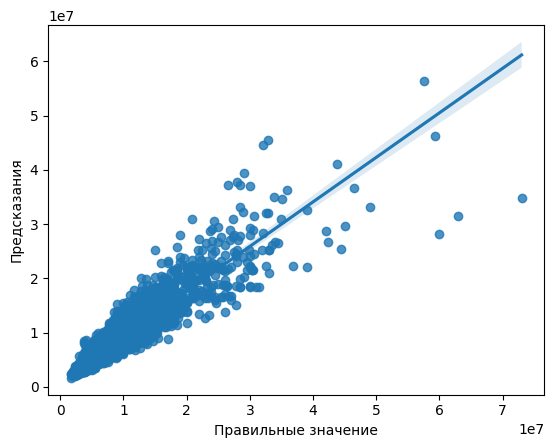

In [221]:
model2 = LinearRegression()
model2.fit(X_train, Y_train)

# X = sm.add_constant(X)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

#pred_1 = np.exp(model2.predict(X))

pred_train = np.exp(model2.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(model2.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# Отобранные фичи

In [73]:
df = pd.read_excel('All.xlsx', sheet_name = 0)
df.head(5)

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154


In [74]:
encoder = LabelEncoder()

df['Ремонт_бин_enc'] = encoder.fit_transform(df[['Ремонт_бин']])
df['Этаж_4_enc'] = encoder.fit_transform(df[['Этаж_4']])
df

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем,Ремонт_бин_enc,Этаж_4_enc
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,первый_последний,17,2023,предчистовая,требует_ремонта,39.043307,45.078162,6738.601246,от_5000_до_10000,от_28_до_43,3851,1,0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1


In [75]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X_cyti = df[['Город']]

X = df[['ОПлощадь', 'Этаж_4_enc', 
        'Этажность_1', 'ГП', 'Ремонт_бин_enc', 
        'Долгота', 'Широта', 'Раст_центр_1', 'Объем'
       ]]

Y = df['LN(Цена)'] #'Цена' LN(Цена)

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34875 entries, 0 to 34874
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ОПлощадь        34875 non-null  float64
 1   Этаж_4_enc      34875 non-null  int32  
 2   Этажность_1     34875 non-null  int64  
 3   ГП              34875 non-null  int64  
 4   Ремонт_бин_enc  34875 non-null  int32  
 5   Долгота         34875 non-null  float64
 6   Широта          34875 non-null  float64
 7   Раст_центр_1    34875 non-null  float64
 8   Объем           34875 non-null  int64  
dtypes: float64(4), int32(2), int64(3)
memory usage: 2.1 MB


In [77]:
# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Создаем новые DF для масштабированных признаков
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

X_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294


In [78]:
# Создаем полиномиальные признаки
degree = 3

poly = PolynomialFeatures(degree = degree, include_bias = False) #include_bias=False
X_poly = poly.fit_transform(X_scaled)

X_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names_out(X.columns))
X_poly

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,...,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Широта Раст_центр_1^2,Широта Раст_центр_1 Объем,Широта Объем^2,Раст_центр_1^3,Раст_центр_1^2 Объем,Раст_центр_1 Объем^2,Объем^3
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.472942,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.467602,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,0.308429,...,-0.747718,0.028277,0.722720,-0.001069,-0.027331,-0.698559,0.000040,0.001034,0.026418,0.675205
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205


Используем PolynomialFeatures для создания полиномиальных и перекрестных признаков. Степень полинома контролируется параметром degree. include_bias=False убирает столбец из 1, так как OLS регрессия добавит столбец из 1 для константы (intercept).

In [79]:
list(X_poly.columns)

['ОПлощадь',
 'Этаж_4_enc',
 'Этажность_1',
 'ГП',
 'Ремонт_бин_enc',
 'Долгота',
 'Широта',
 'Раст_центр_1',
 'Объем',
 'ОПлощадь^2',
 'ОПлощадь Этаж_4_enc',
 'ОПлощадь Этажность_1',
 'ОПлощадь ГП',
 'ОПлощадь Ремонт_бин_enc',
 'ОПлощадь Долгота',
 'ОПлощадь Широта',
 'ОПлощадь Раст_центр_1',
 'ОПлощадь Объем',
 'Этаж_4_enc^2',
 'Этаж_4_enc Этажность_1',
 'Этаж_4_enc ГП',
 'Этаж_4_enc Ремонт_бин_enc',
 'Этаж_4_enc Долгота',
 'Этаж_4_enc Широта',
 'Этаж_4_enc Раст_центр_1',
 'Этаж_4_enc Объем',
 'Этажность_1^2',
 'Этажность_1 ГП',
 'Этажность_1 Ремонт_бин_enc',
 'Этажность_1 Долгота',
 'Этажность_1 Широта',
 'Этажность_1 Раст_центр_1',
 'Этажность_1 Объем',
 'ГП^2',
 'ГП Ремонт_бин_enc',
 'ГП Долгота',
 'ГП Широта',
 'ГП Раст_центр_1',
 'ГП Объем',
 'Ремонт_бин_enc^2',
 'Ремонт_бин_enc Долгота',
 'Ремонт_бин_enc Широта',
 'Ремонт_бин_enc Раст_центр_1',
 'Ремонт_бин_enc Объем',
 'Долгота^2',
 'Долгота Широта',
 'Долгота Раст_центр_1',
 'Долгота Объем',
 'Широта^2',
 'Широта Раст_центр_1

In [80]:
# Делим имеющуюся выборку на обучающую и тестовую
random_state = 42

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = random_state)
vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = random_state)
kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = random_state)
kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = random_state)

In [81]:
combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
#combined_train

In [82]:
X_poly_selected = X_poly[['ОПлощадь',
                         'Этаж_4_enc',
                         'Этажность_1',
                         #'ГП',
                         'Ремонт_бин_enc',
                         'Долгота',
                         'Широта',
                         'Раст_центр_1',
                         'Объем',
                         'ОПлощадь^2',
                         'ОПлощадь Этаж_4_enc',
                         #'ОПлощадь Этажность_1',
                         'ОПлощадь ГП',
                         'ОПлощадь Ремонт_бин_enc',
                         #'ОПлощадь Долгота',
                         #'ОПлощадь Широта',
                         'ОПлощадь Раст_центр_1',
                         #'ОПлощадь Объем',
                         'Этаж_4_enc^2',
                         'Этаж_4_enc Этажность_1',
                         #'Этаж_4_enc ГП',
                         'Этаж_4_enc Ремонт_бин_enc',
                         'Этаж_4_enc Долгота',
                         'Этаж_4_enc Широта',
                         #'Этаж_4_enc Раст_центр_1',
                         'Этаж_4_enc Объем',
                         #'Этажность_1^2',
                         #'Этажность_1 ГП',
                         'Этажность_1 Ремонт_бин_enc',
                         #'Этажность_1 Долгота',
                         'Этажность_1 Широта',
                         #'Этажность_1 Раст_центр_1',
                         #'Этажность_1 Объем',
                         'ГП^2',
                         #'ГП Ремонт_бин_enc',
                         'ГП Долгота',
                         'ГП Широта',
                         'ГП Раст_центр_1',
                         #'ГП Объем',
                         'Ремонт_бин_enc^2',
                         'Ремонт_бин_enc Долгота',
                         'Ремонт_бин_enc Широта',
                         #'Ремонт_бин_enc Раст_центр_1',
                         'Ремонт_бин_enc Объем',
                         'Долгота^2',
                         'Долгота Широта',
                         'Долгота Раст_центр_1',
                         #'Долгота Объем',
                         #'Широта^2',
                         'Широта Раст_центр_1',
                         #'Широта Объем',
                         'Раст_центр_1^2',
                         #'Раст_центр_1 Объем',
                         'Объем^2',
                         #'ОПлощадь^3',
                         #'ОПлощадь^2 Этаж_4_enc',
                         #'ОПлощадь^2 Этажность_1',
                         #'ОПлощадь^2 ГП',
                         #'ОПлощадь^2 Ремонт_бин_enc',
                         #'ОПлощадь^2 Долгота',
                         #'ОПлощадь^2 Широта',
                         #'ОПлощадь^2 Раст_центр_1',
                         #'ОПлощадь^2 Объем',
                         'ОПлощадь Этаж_4_enc^2',
                         #'ОПлощадь Этаж_4_enc Этажность_1',
                         #'ОПлощадь Этаж_4_enc ГП',
                         #'ОПлощадь Этаж_4_enc Ремонт_бин_enc',
                         #'ОПлощадь Этаж_4_enc Долгота',
                         #'ОПлощадь Этаж_4_enc Широта',
                         #'ОПлощадь Этаж_4_enc Раст_центр_1',
                         #'ОПлощадь Этаж_4_enc Объем',
                         #'ОПлощадь Этажность_1^2',
                         #'ОПлощадь Этажность_1 ГП',
                         #'ОПлощадь Этажность_1 Ремонт_бин_enc',
                         #'ОПлощадь Этажность_1 Долгота',
                         #'ОПлощадь Этажность_1 Широта',
                         #'ОПлощадь Этажность_1 Раст_центр_1',
                         #'ОПлощадь Этажность_1 Объем',
                         #'ОПлощадь ГП^2',
                         #'ОПлощадь ГП Ремонт_бин_enc',
                         #'ОПлощадь ГП Долгота',
                         #'ОПлощадь ГП Широта',
                         #'ОПлощадь ГП Раст_центр_1',
                         'ОПлощадь ГП Объем',
                         'ОПлощадь Ремонт_бин_enc^2',
                         #'ОПлощадь Ремонт_бин_enc Долгота',
                         #'ОПлощадь Ремонт_бин_enc Широта',
                         #'ОПлощадь Ремонт_бин_enc Раст_центр_1',
                         #'ОПлощадь Ремонт_бин_enc Объем',
                         #'ОПлощадь Долгота^2',
                         #'ОПлощадь Долгота Широта',
                         #'ОПлощадь Долгота Раст_центр_1',
                         #'ОПлощадь Долгота Объем',
                         #'ОПлощадь Широта^2',
                         #'ОПлощадь Широта Раст_центр_1',
                         #'ОПлощадь Широта Объем',
                         #'ОПлощадь Раст_центр_1^2',
                         #'ОПлощадь Раст_центр_1 Объем',
                         #'ОПлощадь Объем^2',
                         #'Этаж_4_enc^3',
                         'Этаж_4_enc^2 Этажность_1',
                         #'Этаж_4_enc^2 ГП',
                         'Этаж_4_enc^2 Ремонт_бин_enc',
                         'Этаж_4_enc^2 Долгота',
                         'Этаж_4_enc^2 Широта',
                         #'Этаж_4_enc^2 Раст_центр_1',
                         'Этаж_4_enc^2 Объем',
                         #'Этаж_4_enc Этажность_1^2',
                         #'Этаж_4_enc Этажность_1 ГП',
                         #'Этаж_4_enc Этажность_1 Ремонт_бин_enc',
                         #'Этаж_4_enc Этажность_1 Долгота',
                         #'Этаж_4_enc Этажность_1 Широта',
                         #'Этаж_4_enc Этажность_1 Раст_центр_1',
                         #'Этаж_4_enc Этажность_1 Объем',
                         #'Этаж_4_enc ГП^2',
                         #'Этаж_4_enc ГП Ремонт_бин_enc',
                         #'Этаж_4_enc ГП Долгота',
                         #'Этаж_4_enc ГП Широта',
                         #'Этаж_4_enc ГП Раст_центр_1',
                         #'Этаж_4_enc ГП Объем',
                         'Этаж_4_enc Ремонт_бин_enc^2',
                         #'Этаж_4_enc Ремонт_бин_enc Долгота',
                         #'Этаж_4_enc Ремонт_бин_enc Широта',
                         #'Этаж_4_enc Ремонт_бин_enc Раст_центр_1',
                         #'Этаж_4_enc Ремонт_бин_enc Объем',
                         #'Этаж_4_enc Долгота^2',
                         #'Этаж_4_enc Долгота Широта',
                         #'Этаж_4_enc Долгота Раст_центр_1',
                         #'Этаж_4_enc Долгота Объем',
                         #'Этаж_4_enc Широта^2',
                         #'Этаж_4_enc Широта Раст_центр_1',
                         #'Этаж_4_enc Широта Объем',
                         #'Этаж_4_enc Раст_центр_1^2',
                         #'Этаж_4_enc Раст_центр_1 Объем',
                         #'Этаж_4_enc Объем^2',
                         #'Этажность_1^3',
                         #'Этажность_1^2 ГП',
                         #'Этажность_1^2 Ремонт_бин_enc',
                         #'Этажность_1^2 Долгота',
                         #'Этажность_1^2 Широта',
                         #'Этажность_1^2 Раст_центр_1',
                         #'Этажность_1^2 Объем',
                         'Этажность_1 ГП^2',
                         #'Этажность_1 ГП Ремонт_бин_enc',
                         #'Этажность_1 ГП Долгота',
                         #'Этажность_1 ГП Широта',
                         'Этажность_1 ГП Раст_центр_1',
                         #'Этажность_1 ГП Объем',
                         'Этажность_1 Ремонт_бин_enc^2',
                         #'Этажность_1 Ремонт_бин_enc Долгота',
                         #'Этажность_1 Ремонт_бин_enc Широта',
                         #'Этажность_1 Ремонт_бин_enc Раст_центр_1',
                         #'Этажность_1 Ремонт_бин_enc Объем',
                         'Этажность_1 Долгота^2',
                         'Этажность_1 Долгота Широта',
                         #'Этажность_1 Долгота Раст_центр_1',
                         #'Этажность_1 Долгота Объем',
                         #'Этажность_1 Широта^2',
                         #'Этажность_1 Широта Раст_центр_1',
                         #'Этажность_1 Широта Объем',
                         #'Этажность_1 Раст_центр_1^2',
                         #'Этажность_1 Раст_центр_1 Объем',
                         #'Этажность_1 Объем^2',
                         #'ГП^3',
                         #'ГП^2 Ремонт_бин_enc',
                         #'ГП^2 Долгота',
                         #'ГП^2 Широта',
                         #'ГП^2 Раст_центр_1',
                         #'ГП^2 Объем',
                         #'ГП Ремонт_бин_enc^2',
                         #'ГП Ремонт_бин_enc Долгота',
                         #'ГП Ремонт_бин_enc Широта',
                         #'ГП Ремонт_бин_enc Раст_центр_1',
                         #'ГП Ремонт_бин_enc Объем',
                         'ГП Долгота^2',
                         'ГП Долгота Широта',
                         #'ГП Долгота Раст_центр_1',
                         #'ГП Долгота Объем',
                         #'ГП Широта^2',
                         #'ГП Широта Раст_центр_1',
                         #'ГП Широта Объем',
                         'ГП Раст_центр_1^2',
                         #'ГП Раст_центр_1 Объем',
                         #'ГП Объем^2',
                         'Ремонт_бин_enc^3',
                         'Ремонт_бин_enc^2 Долгота',
                         'Ремонт_бин_enc^2 Широта',
                         #'Ремонт_бин_enc^2 Раст_центр_1',
                         'Ремонт_бин_enc^2 Объем',
                         #'Ремонт_бин_enc Долгота^2',
                         #'Ремонт_бин_enc Долгота Широта',
                         #'Ремонт_бин_enc Долгота Раст_центр_1',
                         #'Ремонт_бин_enc Долгота Объем',
                         #'Ремонт_бин_enc Широта^2',
                         #'Ремонт_бин_enc Широта Раст_центр_1',
                         #'Ремонт_бин_enc Широта Объем',
                         #'Ремонт_бин_enc Раст_центр_1^2',
                         #'Ремонт_бин_enc Раст_центр_1 Объем',
                         #'Ремонт_бин_enc Объем^2',
                         #'Долгота^3',
                         #'Долгота^2 Широта',
                         'Долгота^2 Раст_центр_1',
                         'Долгота^2 Объем',
                         #'Долгота Широта^2',
                         #'Долгота Широта Раст_центр_1',
                         #'Долгота Широта Объем',
                         #'Долгота Раст_центр_1^2',
                         #'Долгота Раст_центр_1 Объем',
                         'Долгота Объем^2',
                         'Широта^3',
                         'Широта^2 Раст_центр_1',
                         'Широта^2 Объем',
                         #'Широта Раст_центр_1^2',
                         #'Широта Раст_центр_1 Объем',
                         #'Широта Объем^2',
                         'Раст_центр_1^3',
                         #'Раст_центр_1^2 Объем',
                         #'Раст_центр_1 Объем^2',
                         #'Объем^3'
                         ]]

In [83]:
X_train, X_test = X_poly_selected.loc[combined_train.index], X_poly_selected.loc[combined_test.index]
Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]

                            OLS Regression Results                            
Dep. Variable:               LN(Цена)   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     4353.
Date:                Mon, 06 Jan 2025   Prob (F-statistic):               0.00
Time:                        14:01:02   Log-Likelihood:                 10186.
No. Observations:               27898   AIC:                        -2.027e+04
Df Residuals:                   27849   BIC:                        -1.987e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

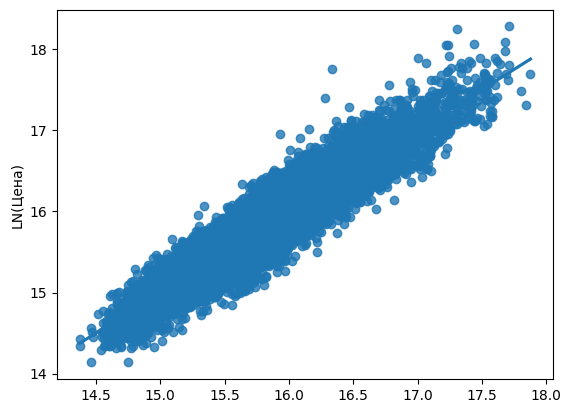

In [84]:
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model = sm.OLS(Y_train, X)
results = model.fit()
print(results.summary())
#r = results.predict(X)
#r = np.array(results)

# Строим график
sns.regplot(x = results.fittedvalues.copy().values, y = Y_train)
plt.show()

In [85]:
d = pd.read_html(results.summary().tables[1].as_html(), header = 0, index_col = 0)[0]
d['P>|t|'].sort_values(ascending = False)

C:\Users\skapr\AppData\Local\Temp\ipykernel_17632\601535931.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(results.summary().tables[1].as_html(), header = 0, index_col = 0)[0]


const                           0.0
ОПлощадь                        0.0
Раст_центр_1^2                  0.0
Объем^2                         0.0
ОПлощадь Этаж_4_enc^2           0.0
ОПлощадь ГП Объем               0.0
ОПлощадь Ремонт_бин_enc^2       0.0
Этаж_4_enc^2 Этажность_1        0.0
Этаж_4_enc^2 Ремонт_бин_enc     0.0
Этаж_4_enc^2 Долгота            0.0
Этаж_4_enc^2 Широта             0.0
Этаж_4_enc^2 Объем              0.0
Этаж_4_enc Ремонт_бин_enc^2     0.0
Этажность_1 ГП^2                0.0
Этажность_1 ГП Раст_центр_1     0.0
Этажность_1 Ремонт_бин_enc^2    0.0
Этажность_1 Долгота^2           0.0
Этажность_1 Долгота Широта      0.0
ГП Долгота^2                    0.0
ГП Долгота Широта               0.0
ГП Раст_центр_1^2               0.0
Ремонт_бин_enc^3                0.0
Ремонт_бин_enc^2 Долгота        0.0
Ремонт_бин_enc^2 Широта         0.0
Ремонт_бин_enc^2 Объем          0.0
Долгота^2 Раст_центр_1          0.0
Долгота^2 Объем                 0.0
Долгота Объем^2             

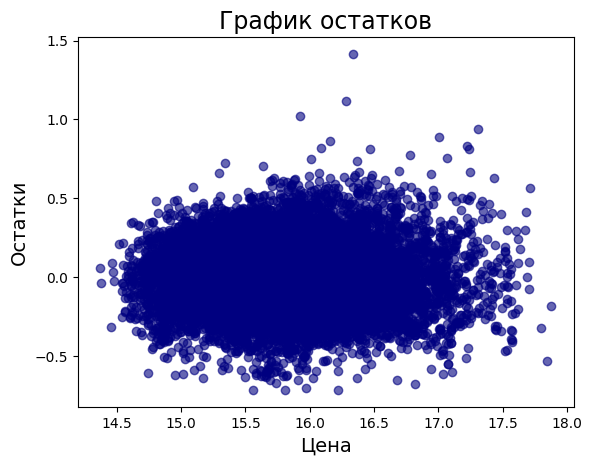

In [86]:
# Строим график остатков обучающей выборки
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)
plt.xlabel('Цена', fontsize = 14)
plt.ylabel('Остатки', fontsize = 14)
plt.title('График остатков', fontsize = 17)
plt.show()

C:\Users\skapr\AppData\Local\Temp\ipykernel_17632\681464043.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, color = 'navy')


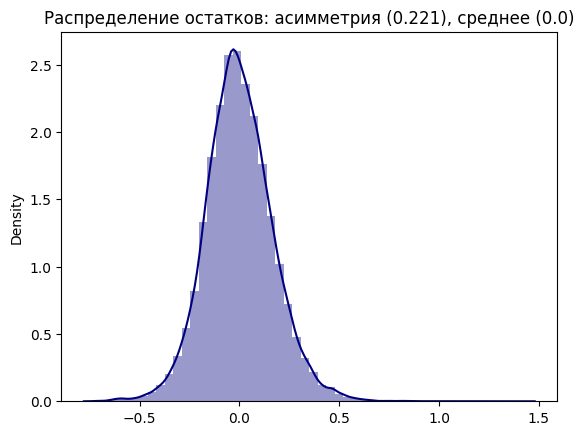

In [87]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean=round(results.resid.mean(), 3)
resid_skew=round(results.resid.skew(), 3)

sns.distplot(results.resid, color = 'navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize=12)
plt.show()

BIC - информационный критерий. Похож на AIC, но имеет более высокий штраф для моделей с большим количеством параметров. Чем меньше значение, тем лучше.

Omnibus - тест на асимметрию и эксцесс остатков. Мы надеемся увидеть значение, близкое к нулю, которое указывало бы на нормальность. The Prob (Omnibus) выполняет статистический тест, показывающий вероятность того, что остатки нормально распределены. Мы надеемся увидеть здесь что-то близкое к 1. В случае если Omnibus относительно низок, а Prob (Omnibus) относительно высок, остатки в целом нормальны, но не идеальны. Подход с линейной регрессией, вероятно, будет лучше, чем случайное угадывание, но, вероятно, хуже нелинейных подходов.

Skew - мера симметрии данных. Мы хотим видеть что-то близкое к нулю, это указывает на то, что остаточное распределение нормально.

Kurtosis - это мера «пиковости» или кривизны данных. Более высокие пики приводят к большему куртозу. Большой куртоз можно интерпретировать как более плотную кластеризацию остатков около нуля, что подразумевает лучшую модель с небольшим количеством выбросов (т.е. чем больше, тем лучше).

Cond. No. - значения больше 20 вызывают подозрения в мультиколлинеарности. Чаще всего сложно пройти данный тест. Чем меньше, тем лучше.

R2 - насколько переменные хорошо объясняют разброс оценок. Максимальное значение – 1. Но при значениях более 0,9 надо крайне внимательно проверить на эффект мультиколлинеарности. Adj. R-squared - это нормированный R2, который используется для сравнения моделей регрессии (как AIC и BIC).

Durbin-Watson - тест на наличие автокорреляции в остатках. В идеале значение должно стремиться к 2 (минимальное значение – 0, максимальное – 4). Значения меньше 0,8 однозначно указывают на циклические колебания в остатках. Эмпирически считается, что статистика лежит в нормальных пределах, если больше 1,5 и меньше 2,5.

Jarque-Bera (JB) - тест на нормальность остатков. Используется на больших наборах данных, более 2000. По своей сути аналогичен Omnibus. Если Prob(JB)>0.05, то считается, что остатки распределены нормально.

MAE на обучении: 1092780.8904
RMSE на обучении: 1913309.9044
MAPE на обучении: 0.1305
R2 на обучении: 0.8466
MAE на тесте: 1083699.1822
RMSE на тесте: 1885113.6624
MAPE на тесте: 0.1292
R2 на тесте: 0.8484


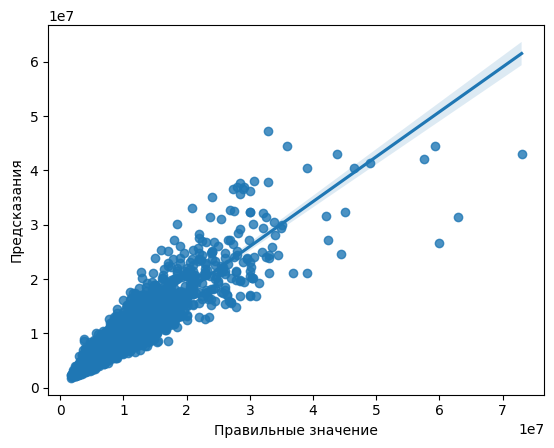

In [88]:
model2 = LinearRegression()
model2.fit(X_train, Y_train)

# X = sm.add_constant(X)
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

#pred_1 = np.exp(model2.predict(X))

pred_train = np.exp(model2.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(model2.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [739]:
random_state = [0, 23, 55, 45, 1, 462, 683, 2351, 7432, 5822]

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

for n, rs in enumerate(random_state):
    print('Обработка процесса №', n)

    ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = rs)
    vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = rs)
    kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = rs)
    kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = rs)
    
    combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
    combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
    
    X_train, X_test = X_poly_selected.loc[combined_train.index], X_poly_selected.loc[combined_test.index]
    Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]
    
    X = sm.add_constant(X_train) # добавляем константу = 1 к факторам
    
    # Строим регрессионную модель
    model = sm.OLS(Y_train, X)
    results = model.fit()
    
    if n == 0:
        coef = pd.DataFrame({f'Коэфф_{n}': results.params})
    else:
        coef[f'Коэфф_{n}'] = results.params.values

coef['min'] = abs(coef).min(axis = 1)
coef['max'] = abs(coef).max(axis = 1)
coef['max/min'] = coef['max'] / coef['min']
coef

Обработка процесса № 0
Обработка процесса № 1
Обработка процесса № 2
Обработка процесса № 3
Обработка процесса № 4
Обработка процесса № 5
Обработка процесса № 6
Обработка процесса № 7
Обработка процесса № 8
Обработка процесса № 9


,Коэфф_0,Коэфф_1,Коэфф_2,Коэфф_3,Коэфф_4,Коэфф_5,Коэфф_6,Коэфф_7,Коэфф_8,Коэфф_9,min,max,max/min
const,4.752840,4.653701,4.663769,4.717021,4.798271,4.798710,4.833108,4.685514,4.727962,4.789543,4.653701,4.833108,1.038552
ОПлощадь,0.218042,0.218534,0.217255,0.218501,0.218890,0.217915,0.218895,0.217923,0.218191,0.218139,0.217255,0.218895,1.007552
Этаж_4_enc,1.929051,1.888399,1.892741,1.914437,1.947419,1.947230,1.961397,1.901656,1.918682,1.943641,1.888399,1.961397,1.038656
Этажность_1,0.044317,0.042520,0.042922,0.040661,0.041319,0.045128,0.041794,0.043913,0.041761,0.043875,0.040661,0.045128,1.109883
Ремонт_бин_enc,-2.243362,-2.196532,-2.201218,-2.226418,-2.264732,-2.264965,-2.281003,-2.211674,-2.231752,-2.260383,2.196532,2.281003,1.038457
Долгота,-2.662213,-2.743472,-2.742333,-2.686201,-2.611596,-2.610279,-2.564371,-2.708748,-2.670436,-2.626219,2.564371,2.743472,1.069842
Широта,5.333714,5.531731,5.479510,5.430139,5.289408,5.285149,5.299060,5.498032,5.432771,5.275760,5.275760,5.531731,1.048518
Раст_центр_1,0.573807,0.558916,0.585875,0.559170,0.499128,0.544430,0.557803,0.563075,0.476162,0.492173,0.476162,0.585875,1.230410
Объем,0.141114,0.140630,0.138840,0.142745,0.141751,0.144670,0.142299,0.144866,0.140068,0.139748,0.138840,0.144866,1.043406
ОПлощадь^2,-0.029581,-0.031571,-0.030023,-0.029921,-0.031801,-0.029481,-0.030103,-0.029146,-0.031060,-0.029097,0.029097,0.031801,1.092925


In [740]:
coef['max/min'].sort_values(ascending = False)

Раст_центр_1                    1.230410
ОПлощадь ГП Объем               1.197506
Широта^2 Раст_центр_1           1.194004
Долгота Раст_центр_1            1.151563
Этажность_1 Долгота Широта      1.150081
Этажность_1 Долгота^2           1.133553
Этаж_4_enc Этажность_1          1.127387
Долгота^2 Раст_центр_1          1.126109
ОПлощадь Раст_центр_1           1.122048
Этажность_1 ГП Раст_центр_1     1.115613
Этажность_1 Широта              1.114742
Этажность_1 Ремонт_бин_enc      1.110852
Этажность_1                     1.109883
Этажность_1 Ремонт_бин_enc^2    1.108840
ГП Раст_центр_1^2               1.101553
ОПлощадь ГП                     1.094876
ОПлощадь^2                      1.092925
Этаж_4_enc^2 Этажность_1        1.090338
Этажность_1 ГП^2                1.089023
ГП Долгота Широта               1.087624
Широта Раст_центр_1             1.078614
Ремонт_бин_enc Долгота          1.070213
Ремонт_бин_enc^2 Долгота        1.069943
Этаж_4_enc^2 Долгота            1.069927
Долгота         

In [89]:
combined_X = pd.concat([X_train, X_test])
combined_X

,ОПлощадь,Этаж_4_enc,Этажность_1,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этаж_4_enc,...,Ремонт_бин_enc^2 Долгота,Ремонт_бин_enc^2 Широта,Ремонт_бин_enc^2 Объем,Долгота^2 Раст_центр_1,Долгота^2 Объем,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Раст_центр_1^3
1514,0.741574,0.508007,1.165252,1.477463,0.067656,1.078856,0.398187,-1.039574,0.549932,0.376725,...,0.147686,2.355031,-2.269283,0.001823,-0.004759,0.073117,1.255713,0.463461,-1.209992,0.063134
265,0.335504,0.508007,-1.177657,1.477463,0.067476,1.077414,0.563481,0.273875,0.112563,0.170439,...,0.147293,2.351883,0.597841,0.002566,0.001247,0.005061,1.250684,0.654100,0.317920,0.178911
0,0.700138,0.508007,1.716525,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,0.355676,...,0.028514,0.496735,-0.476236,-0.000772,-0.004027,0.067266,1.274890,-0.234209,-1.222280,-0.007904
1451,-0.141007,-1.968475,-0.626384,1.477463,0.062977,1.095186,-0.290614,0.273875,0.019883,0.277568,...,0.137471,2.390678,0.597841,-0.001153,0.001086,0.004724,1.313601,-0.348572,0.328494,-0.024544
3570,-0.161724,0.508007,0.200525,1.477463,0.064719,1.088466,-1.580382,0.273875,0.026155,-0.082157,...,0.141276,2.376009,0.597841,-0.006620,0.001147,0.004854,1.289569,-1.872371,0.324476,-3.947177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21212,0.894886,-1.968475,-0.626384,-0.676836,-0.323455,0.913700,-0.243063,-0.977740,0.800822,-1.761562,...,-0.148177,0.418572,-0.447909,-0.025430,-0.102294,-0.309215,0.762801,-0.202921,-0.816264,-0.014360
18756,-0.472492,0.508007,-0.626384,1.477463,-0.322314,0.914054,0.317368,0.477147,0.223249,-0.240030,...,-0.703577,1.995286,1.041562,0.032970,0.049569,-0.073381,0.763688,0.265159,0.398654,0.031966
17082,0.563401,-1.968475,-1.315475,-0.676836,-0.328274,0.915447,-0.737776,-0.977740,0.317420,-1.109040,...,-0.150384,0.419372,-0.447909,-0.079505,-0.105365,-0.313821,0.767183,-0.618287,-0.819387,-0.401581
19660,-1.487667,-1.968475,-1.177657,-0.676836,-0.324596,0.911352,-0.802858,-1.145475,2.213154,2.928436,...,-0.148700,0.417496,-0.524750,-0.084591,-0.120690,-0.425906,0.756934,-0.666823,-0.951387,-0.517506


In [90]:
combined_X['original_index'] = combined_X.index

combined_X = combined_X.reset_index(drop = True)
combined_X = combined_X.sort_values('original_index').reset_index(drop = True)
combined_X = combined_X.drop('original_index', axis = 1)
combined_X

,ОПлощадь,Этаж_4_enc,Этажность_1,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этаж_4_enc,...,Ремонт_бин_enc^2 Долгота,Ремонт_бин_enc^2 Широта,Ремонт_бин_enc^2 Объем,Долгота^2 Раст_центр_1,Долгота^2 Объем,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Раст_центр_1^3
0,0.700138,0.508007,1.716525,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,0.355676,...,0.028514,0.496735,-0.476236,-0.000772,-0.004027,0.067266,1.274890,-0.234209,-1.222280,-0.007904
1,0.700138,0.508007,1.716525,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,0.355676,...,0.028514,0.496735,-0.476236,-0.000772,-0.004027,0.067266,1.274890,-0.234209,-1.222280,-0.007904
2,0.700138,0.508007,1.716525,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,0.355676,...,0.028514,0.496735,-0.476236,-0.000772,-0.004027,0.067266,1.274890,-0.234209,-1.222280,-0.007904
3,0.700138,0.508007,1.716525,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,0.355676,...,0.028514,0.496735,-0.476236,-0.000772,-0.004027,0.067266,1.274890,-0.234209,-1.222280,-0.007904
4,0.687708,0.508007,1.716525,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.472942,0.349361,...,0.028514,0.496735,-0.476236,-0.000772,-0.004027,0.067266,1.274890,-0.234209,-1.222280,-0.007904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.467602,-0.347383,...,-1.461752,-1.980935,1.915042,-0.010214,0.393393,-0.515384,-0.747328,-0.018758,0.722469,-0.000012
34871,-0.555364,-1.968475,0.476161,1.477463,-0.669481,-0.907638,0.034325,0.877294,0.308429,1.093220,...,-1.461408,-1.981280,1.915042,0.015384,0.393208,-0.515263,-0.747718,0.028277,0.722720,0.000040
34872,-0.696245,0.508007,1.440889,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,-0.353698,...,-1.461752,-1.980935,1.915042,-0.010214,0.393393,-0.515384,-0.747328,-0.018758,0.722469,-0.000012
34873,-0.696245,0.508007,1.440889,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,-0.353698,...,-1.461752,-1.980935,1.915042,-0.010214,0.393393,-0.515384,-0.747328,-0.018758,0.722469,-0.000012


In [91]:
pred_1 = np.exp(model2.predict(combined_X))
pred_1

array([7796388.27361122, 7796388.27361122, 7796388.27361122, ...,
       4741464.86631314, 4741501.04095726, 4751205.80073528])

In [92]:
combined_Y = pd.concat([pd.DataFrame(Y_train), pd.DataFrame(Y_test)])
combined_Y['original_index'] = combined_Y.index

combined_Y = combined_Y.reset_index(drop = True)
combined_Y = combined_Y.sort_values('original_index').reset_index(drop = True)
combined_Y = combined_Y.drop('original_index', axis = 1)
combined_Y

,LN(Цена)
0,15.761421
1,15.761421
2,15.761421
3,15.775605
4,15.761421
...,...
34870,15.623799
34871,15.606937
34872,15.520259
34873,15.496152


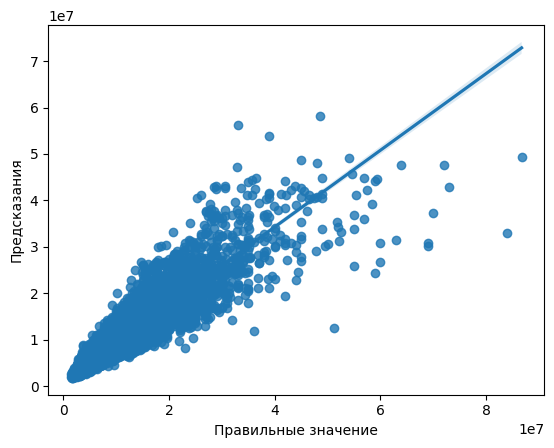

In [93]:
sns.regplot(x = np.exp(combined_Y), y = pred_1)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [751]:
#Сохраняем в Excel
writer = pd.ExcelWriter('All_прогноз.xlsx')
pd.DataFrame(pred_1).to_excel(writer, 'прогноз')
writer._save()

In [94]:
#матрицу ковариаций
results.cov_params()

,const,ОПлощадь,Этаж_4_enc,Этажность_1,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,...,Ремонт_бин_enc^2 Долгота,Ремонт_бин_enc^2 Широта,Ремонт_бин_enc^2 Объем,Долгота^2 Раст_центр_1,Долгота^2 Объем,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Раст_центр_1^3
const,8.769578e-03,1.390811e-06,3.554392e-03,-4.821741e-07,-4.118568e-03,8.165152e-03,-1.385848e-02,4.981300e-04,-3.628678e-05,1.259952e-07,...,4.973707e-03,-8.446625e-03,-2.283506e-05,-1.011501e-04,7.338593e-06,1.459449e-05,9.156420e-03,-3.887262e-04,7.384268e-05,-2.366872e-06
ОПлощадь,1.390811e-06,7.237473e-07,5.619592e-07,-1.660854e-07,-6.655273e-07,9.778817e-07,-3.216286e-06,-4.263539e-07,9.517081e-07,-1.291782e-07,...,5.592335e-07,-1.978630e-06,5.093791e-07,4.871729e-08,-4.139863e-07,-4.869980e-07,3.353958e-06,5.500561e-07,-1.592199e-06,1.301128e-08
Этаж_4_enc,3.554392e-03,5.619592e-07,1.440743e-03,-2.399570e-07,-1.669312e-03,3.309291e-03,-5.617241e-03,2.019464e-04,-1.471294e-05,5.442395e-08,...,2.015816e-03,-3.423661e-03,-9.253868e-06,-4.101452e-05,2.954827e-06,5.893187e-06,3.711739e-03,-1.575809e-04,2.993770e-05,-9.569986e-07
Этажность_1,-4.821741e-07,-1.660854e-07,-2.399570e-07,7.760967e-06,2.567080e-07,-2.529571e-06,-3.640732e-06,6.995711e-06,-7.922160e-07,2.641806e-08,...,-1.558370e-06,-2.294575e-06,-5.103233e-07,-6.101957e-07,2.262482e-07,2.894747e-07,8.555047e-06,-5.825149e-06,1.716296e-06,1.680238e-08
Ремонт_бин_enc,-4.118568e-03,-6.655273e-07,-1.669312e-03,2.567080e-07,1.934329e-03,-3.834640e-03,6.508785e-03,-2.344791e-04,1.704176e-05,-5.607765e-08,...,-2.335817e-03,3.967069e-03,1.071976e-05,4.761059e-05,-3.437221e-06,-6.849185e-06,-4.300622e-03,1.830016e-04,-3.467708e-05,1.111894e-06
Долгота,8.165152e-03,9.778817e-07,3.309291e-03,-2.529571e-06,-3.834640e-03,7.765518e-03,-1.225914e-02,6.263546e-05,-3.639976e-05,1.540613e-07,...,4.729967e-03,-7.472078e-03,-2.309867e-05,2.170717e-05,7.125982e-06,1.424003e-05,7.416648e-03,-7.801787e-05,7.581899e-05,-2.116280e-06
Широта,-1.385848e-02,-3.216286e-06,-5.617241e-03,-3.640732e-06,6.508785e-03,-1.225914e-02,2.456470e-02,-2.421122e-03,7.160746e-05,-3.437864e-07,...,-7.467844e-03,1.497106e-02,4.443700e-05,6.338882e-04,-1.634369e-05,-2.878022e-05,-1.904934e-02,1.770268e-03,-1.459431e-04,4.758690e-06
Раст_центр_1,4.981300e-04,-4.263539e-07,2.019464e-04,6.995711e-06,-2.344791e-04,6.263546e-05,-2.421122e-03,6.355602e-03,-1.007653e-05,-1.933614e-07,...,3.841660e-05,-1.475900e-03,-5.625250e-06,-1.735528e-03,3.478276e-06,2.927747e-06,3.320221e-03,-4.608432e-03,2.101275e-05,-7.716656e-06
Объем,-3.628678e-05,9.517081e-07,-1.471294e-05,-7.922160e-07,1.704176e-05,-3.639976e-05,7.160746e-05,-1.007653e-05,5.426039e-05,1.124225e-07,...,-2.229660e-05,4.351905e-05,3.278689e-05,8.958262e-09,-1.796821e-05,-2.702053e-05,-6.188675e-05,1.015947e-05,-1.158534e-04,-5.516881e-08
ОПлощадь^2,1.259952e-07,-1.291782e-07,5.442395e-08,2.641806e-08,-5.607765e-08,1.540613e-07,-3.437864e-07,-1.933614e-07,1.124225e-07,2.050942e-07,...,9.619758e-08,-2.077822e-07,7.069939e-08,5.724608e-08,1.139527e-08,-4.662545e-08,3.226539e-07,1.333872e-07,-1.547229e-07,-1.126513e-09


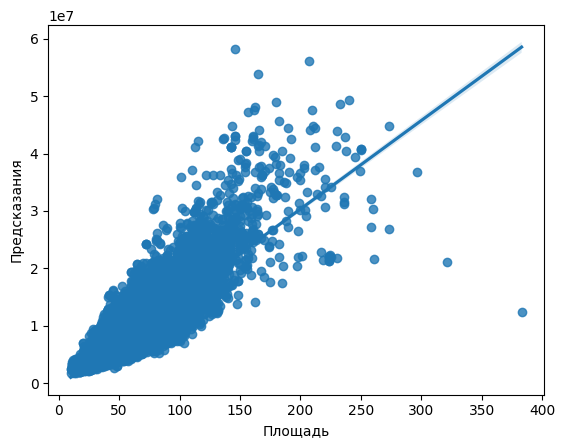

In [95]:
sns.regplot(x = df['ОПлощадь'], y = pred_1)
plt.xlabel('Площадь')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

# Расчет интервала цен

In [101]:
# Исходим из цены квартиры
# Считаем классическое стандартное отклонение по интервалам цены

# Вычисляем остатки
df['Predicted_Price'] = pred_1
df['Residuals'] = df['Цена'] - df['Predicted_Price']

# Группируем по площади
bins = [0, 10000000, 20000000, 40000000, np.inf]
labels = ['<=10 mln', '10-20 mln', '20-40 mln', '>40 mln']
df['Area_Group'] = pd.cut(df['Цена'], bins = bins, labels = labels)

# Рассчитываем стандартное отклонение для каждой группы
grouped = df.groupby('Area_Group')['Residuals'].apply(lambda x: np.std(x))
grouped

C:\Users\skapr\AppData\Local\Temp\ipykernel_17632\210913920.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Area_Group')['Residuals'].apply(lambda x: np.std(x))


Area_Group
<=10 mln     9.826675e+05
10-20 mln    2.457650e+06
20-40 mln    5.677103e+06
>40 mln      1.167580e+07
Name: Residuals, dtype: float64

Такой способ нам не подходит, так как, например, +-982667.5 руб. слишком большой коридор цен для квартир стоимостью до 3 млн. руб.

In [102]:
df.columns

Index(['LN(Цена)', 'Цена', 'Город', 'ОПлощадь', 'Этаж_1', 'Этаж_2', 'Этаж_3',
       'Этаж_4', 'Этажность_1', 'ГП', 'Ремонт_перв', 'Ремонт_бин', 'Долгота',
       'Широта', 'Раст_центр_1', 'Раст_центр_2', 'S_инт', 'Объем',
       'Ремонт_бин_enc', 'Этаж_4_enc', 'Predicted_Price', 'Residuals',
       'Area_Group'],
      dtype='object')

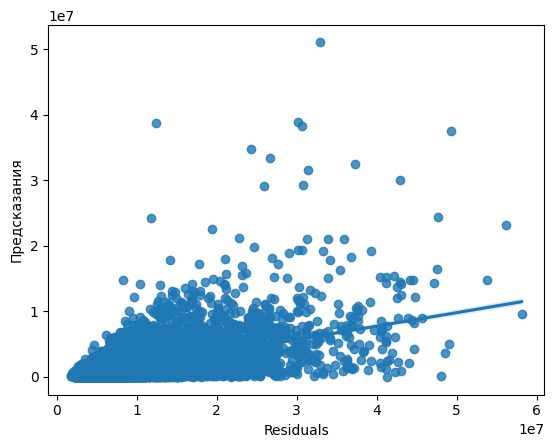

In [127]:
#sns.regplot(x = df['ОПлощадь'], y = np.abs(df['Residuals']))
sns.regplot(x = df['Predicted_Price'], y = np.abs(df['Residuals']))
plt.xlabel('Residuals')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [167]:
# Используем линейную регрессию для прогнозирования стандартного отклонения по цене
X1 = np.log(df['Predicted_Price'])
Y1 = np.log(np.abs(df['Residuals']))  # Моделируем абсолютные ошибки, берем log для исключения отрицательных значений при прогнозе

#regressor = LinearRegression()
#regressor.fit(X, y)

X_ols = sm.add_constant(X1) # добавляем константу = 1 к факторам

# Строим регрессионную модель
model_resid = sm.OLS(Y1, X_ols)
results_resid = model_resid.fit()
print(results_resid.summary())

                            OLS Regression Results                            
Dep. Variable:              Residuals   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     9086.
Date:                Mon, 06 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:22:53   Log-Likelihood:                -53677.
No. Observations:               34875   AIC:                         1.074e+05
Df Residuals:                   34873   BIC:                         1.074e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.4069      0.206    -

Обращаю внимание, что при расчете интервалов качество модели (R2 = 0.207) не так важно, самое главное, что она отражает тенденцию.

In [168]:
coefficients = results_resid.params
print("Intercept:", coefficients['const'])
print("Slope:", coefficients['Predicted_Price'])

Intercept: -6.4068547703935685
Slope: 1.249701757670761


In [169]:
df['Residuals_pred'] = results_resid.predict(X_ols)

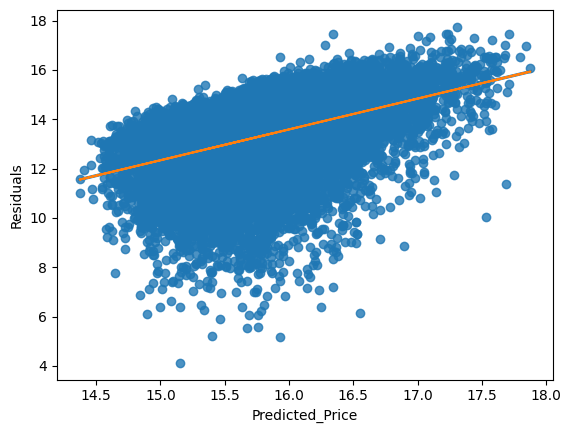

In [173]:
sns.regplot(x = np.log(df['Predicted_Price']), y = np.log(np.abs(df['Residuals'])))
plt.plot(np.log(df['Predicted_Price']), df['Residuals_pred'])

In [220]:
p = 14
k = 1.5

Y_1 = [1, p]

print('Цена квартиры:', np.exp(p))

pr = np.exp(results_resid.predict(Y_1)) * k

print('Интервал:', pr[0])
print('Интервал (доля):',pr[0] / np.exp(p))

Цена квартиры: 1202604.2841647768
Интервал: 98167.93810007564
Интервал (доля): 0.08162945982539424


# Подбор множителя k

1. Использование статистики Стьюдента
Если ошибки модели (ResidualsResidualsResiduals) можно считать нормально распределенными в каждой группе (или в целом), то множитель k можно выбрать на основе распределения Стьюдента t-распределения.

In [225]:
from scipy.stats import t

# Параметры
alpha = 0.13  # Доверительный уровень 87%
n = len(df)  # Число наблюдений
p = 1 #X.shape[1]  # Число факторов (без учета intercept)
nu = n - p - 1  # Степени свободы

# Критическое значение t
k = t.ppf(1 - alpha / 2, df = nu)
print(f"Mножитель k: {k}")

Mножитель k: 1.5141376266340119


2. Эмпирический подход: Множитель из анализа распределения остатков
Если остатки (ResidualsResidualsResiduals) не следуют нормальному распределению или их характер варьируется по группам (гетероскедастичность):

•	Рассчитайте распределение ошибок для каждой группы (например, площадей).

•	Подберите k, чтобы покрыть 95% или другой процент ошибок.

In [221]:
import numpy as np

# Абсолютные ошибки (остатки)
absolute_errors = np.abs(df['Residuals'])  # Возьмем модуль остатков

# Рассчитаем стандартное отклонение остатков
std_error = np.std(absolute_errors)

# Рассчитаем множитель k для покрытия 80% остатков
alpha = 0.20  # Для доверительного интервала 80%
k = np.percentile(absolute_errors / std_error, 100 * (1 - alpha / 2))  # Нормируем на стандартное отклонение

print(f"Множитель k: {k}")

Множитель k: 1.5136504375257371


3. Использование Z-статистики (если остатки близки к норме)
Для больших выборок (n>30) можно использовать стандартное нормальное распределение (Z-распределение) вместо t-распределения.
Критические значения Z:

•	Z=1.645: для 90% доверительного интервала,

•	Z=1.96: для 95% доверительного интервала,

•	Z=2.576: для 99% доверительного интервала.


4. Оценка k через перекрытие интервалов
Если ваша цель — задать интервалы так, чтобы определенный процент истинных цен квартир попадал в них:

•	Рассчитайте интервалы для тестового набора данных с разными k.

•	Проверьте долю квартир, истинные цены которых лежат в интервалах.

•	Выберите k, который обеспечивает требуемый процент попаданий.

In [ ]:
# Определим целевую долю попаданий (например, 95%)
target_coverage = 0.95
best_k = None

for k in np.arange(1, 3, 0.1):  # Перебираем значения k
    coverage = ((df['True_Price'] >= df['Predicted_Price'] - k * df['Predicted_Std_Error']) &
                (df['True_Price'] <= df['Predicted_Price'] + k * df['Predicted_Std_Error'])).mean()
    if coverage >= target_coverage:
        best_k = k
        break

print(f"Оптимальный k: {best_k}")

# Robust Regression

Основная идея Robust Regression (устойчивой регрессии) заключается в том, чтобы построить модель регрессии, которая будет менее чувствительна к выбросам (аномальным наблюдениям) в данных. Обычная линейная регрессия (OLS – Ordinary Least Squares) очень сильно подвержена влиянию выбросов, поскольку стремится минимизировать сумму квадратов ошибок, и большие ошибки влекут за собой непропорционально большое увеличение этой суммы. Robust Regression, напротив, пытается минимизировать ошибки, не давая при этом большого веса выбросам.

Основы Robust Regression:

1.  M-оценка (M-estimation):
    *   В основе Robust Regression лежит метод M-оценки, который обобщает метод максимального правдоподобия (maximum likelihood estimation). M-оценка пытается минимизировать функцию потерь, но она выбирает такую функцию, которая уменьшает влияние больших ошибок.
    *   Функция потерь в M-оценке обозначается как ρ (rho). В случае обычной OLS, ρ(r) = r² (где r – это остаток, т.е. разница между наблюдаемым и предсказанным значением).
    *   В Robust Regression используются функции потерь, которые растут медленнее, чем r², при больших значениях r.

2.  Веса:
    *   Обычно, на практике M-оценка реализуется путём итеративного перевзвешивания. Каждому наблюдению присваивается определенный вес в зависимости от величины его остатка.
    *   На наблюдения с большими остатками (потенциальные выбросы) навешиваются меньшие веса, а на наблюдения с меньшими остатками навешиваются большие веса.
    *   Это снижает влияние выбросов на итоговую оценку параметров модели.

3.  Функции потерь (M-Estimators):
    *   Разные функции потерь определяют разную степень "устойчивости" модели к выбросам.
    *   Наиболее популярные функции потерь (M-оценки):
        *   Huber T (Хьюбер): Популярная функция, которая ведет себя как квадратичная функция для малых остатков и как линейная – для больших. Это компромиссный вариант между OLS и полным игнорированием выбросов.
            *   ρ(r) = 0.5 * r² при |r| <= k
            *   ρ(r) = k * |r| - 0.5 * k² при |r| > k (где k – параметр, обычно 1.345)
        *   Bisquare (Биквадрат): Более "агрессивно" снижает вес больших остатков по сравнению с HuberT.
            *   ρ(r) = (c²/6) * [1 - (1 - (r²/c²)³) при |r| <= c
            *   ρ(r) = c²/6 при |r| > c (где c – параметр, обычно 4.685)
        *   Hampel (Хампель): Похожа на HuberT, но имеет 3 "точки переключения", что позволяет более гибко управлять весами.
        *   Andrew's sine (Андрюса синус): Похожа на Bisquare, но имеет плавный переход.
        *   Tukey biweight (Tьюки бивеит): То же самое, что и Bisquare.
        *   Trimmed (Обрезанная): Обрезает самые большие остатки.
        *   Ramsey (Рамсей): Функция потерь имеет вид гиперболического косинуса.

Формула Robust Regression (в общем виде):

Robust Regression пытается минимизировать функцию:

  ∑ ρ(yᵢ - xᵢᵀ β)

Где:

•   ∑ – сумма по всем наблюдениям
•   ρ – функция потерь (одна из M-оценок, например, HuberT)
•   yᵢ – наблюдаемое значение целевой переменной для i-го наблюдения
•   xᵢ – вектор признаков для i-го наблюдения
•   β – вектор коэффициентов модели (параметры, которые нужно оценить)

Алгоритм Robust Regression (итеративно перевзвешенный метод наименьших квадратов – IRLS):

1.  Инициализация: Начните с оценки параметров β используя обычный OLS.
2.  Вычисление остатков: Вычислите остатки: rᵢ = yᵢ - xᵢᵀ β
3.  Вычисление весов: Для каждого наблюдения вычислите вес wᵢ, на основе функции потерь ρ и остатка rᵢ. Веса обычно вычисляют на основе нормированных остатков: uᵢ = rᵢ / scale. Функция весов определяется как w(u) = ρ'(u) / u, где ρ' - это производная функции потерь.
    *   Для HuberT веса:
        *   wᵢ = 1 при |rᵢ / scale| <= k
        *   wᵢ = k / (|rᵢ / scale|) при |rᵢ / scale| > k
4.  Оценка параметров: Оцените параметры β с использованием взвешенного метода наименьших квадратов (WLS):
    *   минимизируйте ∑ wᵢ * (yᵢ - xᵢᵀ β)²
5.  Повторение: Повторяйте шаги 2-4 до тех пор, пока параметры β не перестанут существенно меняться (до сходимости).

Ключевая идея Robust Regression:

Заменить квадратичные потери в OLS на более медленно растущие потери, чтобы большие остатки (выбросы) не оказывали слишком большого влияния на оценку коэффициентов регрессии.

Когда использовать Robust Regression:

•   Когда в данных есть выбросы (аномальные наблюдения).
•   Когда распределение остатков имеет "тяжелые хвосты" (не является нормальным).
•   Когда нужно получить более устойчивые к выбросам оценки параметров.

В заключение:

Robust Regression – мощный инструмент для анализа данных с выбросами. Она построена на идее минимизации ошибок путем их взвешивания с использованием M-оценки и итеративного процесса пересчета весов. Выбор конкретной функции потерь (M-оценки) зависит от особенностей данных и конкретной задачи.

In [25]:
df = pd.read_excel('All.xlsx', sheet_name = 0)
df.head(5)

,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154


In [26]:
encoder = LabelEncoder()

df['Ремонт_бин_enc'] = encoder.fit_transform(df[['Ремонт_бин']])
df['Этаж_4_enc'] = encoder.fit_transform(df[['Этаж_4']])
df

C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\skapr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,LN(Цена),Цена,Город,ОПлощадь,Этаж_1,Этаж_2,Этаж_3,Этаж_4,Этажность_1,ГП,Ремонт_перв,Ремонт_бин,Долгота,Широта,Раст_центр_1,Раст_центр_2,S_инт,Объем,Ремонт_бин_enc,Этаж_4_enc
0,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
1,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
2,15.761421,7000000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
3,15.775605,7100000,Екатеринбург,70.3,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
4,15.761421,7000000,Екатеринбург,70.0,3,средний,этажи_2-5,средний,26,2009,стандартный,с_ремонтом,60.514731,56.810482,5858.724489,от_5000_до_10000,от_65_до_85,1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,15.623799,6100000,Краснодар,36.9,4,средний,этажи_2-5,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34871,15.606937,5998000,Краснодар,40.0,17,последний,последний,первый_последний,17,2023,предчистовая,требует_ремонта,39.043307,45.078162,6738.601246,от_5000_до_10000,от_28_до_43,3851,1,0
34872,15.520259,5500000,Краснодар,36.6,17,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1
34873,15.496152,5369000,Краснодар,36.6,20,средний,этажи_11-25,средний,24,2022,предчистовая,требует_ремонта,39.038680,45.079091,6523.448481,от_5000_до_10000,от_28_до_43,3851,1,1


In [27]:
# Присваиваем зависимую переменную (цена) Y, а независимые переменные - X
X_cyti = df[['Город']]

X = df[['ОПлощадь', 'Этаж_4_enc', 
        'Этажность_1', 'ГП', 'Ремонт_бин_enc', 
        'Долгота', 'Широта', 'Раст_центр_1', 'Объем'
       ]]

Y = df['LN(Цена)'] #'Цена' LN(Цена)

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34875 entries, 0 to 34874
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ОПлощадь        34875 non-null  float64
 1   Этаж_4_enc      34875 non-null  int32  
 2   Этажность_1     34875 non-null  int64  
 3   ГП              34875 non-null  int64  
 4   Ремонт_бин_enc  34875 non-null  int32  
 5   Долгота         34875 non-null  float64
 6   Широта          34875 non-null  float64
 7   Раст_центр_1    34875 non-null  float64
 8   Объем           34875 non-null  int64  
dtypes: float64(4), int32(2), int64(3)
memory usage: 2.1 MB


Стандартизация/Нормализация:
Обязательно проводите стандартизацию (StandardScaler) или нормализацию (MinMaxScaler) признаков *перед* созданием полиномиальных признаков. Это уменьшит проблему мультиколлинеарности и поможет стабилизировать коэффициенты.

In [29]:
# Масштабируем признаки
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Создаем новые DF для масштабированных признаков
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

X_scaled

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574
...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294


In [30]:
# Создаем полиномиальные признаки
degree = 3

poly = PolynomialFeatures(degree = degree, include_bias = False) #include_bias=False
X_poly = poly.fit_transform(X_scaled)

X_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names_out(X.columns))
X_poly

,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,...,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Широта Раст_центр_1^2,Широта Раст_центр_1 Объем,Широта Объем^2,Раст_центр_1^3,Раст_центр_1^2 Объем,Раст_центр_1 Объем^2,Объем^3
0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
1,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
2,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
3,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.490194,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
4,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,-1.039574,0.472942,...,1.274890,-0.234209,-1.222280,0.043026,0.224544,1.171841,-0.007904,-0.041251,-0.215278,-1.123483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.467602,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205
34871,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.877294,0.308429,...,-0.747718,0.028277,0.722720,-0.001069,-0.027331,-0.698559,0.000040,0.001034,0.026418,0.675205
34872,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205
34873,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.877294,0.484757,...,-0.747328,-0.018758,0.722469,-0.000471,0.018134,-0.698437,-0.000012,0.000455,-0.017531,0.675205


Используем PolynomialFeatures для создания полиномиальных и перекрестных признаков. Степень полинома контролируется параметром degree. include_bias=False убирает столбец из 1, так как OLS регрессия добавит столбец из 1 для константы (intercept).

In [31]:
X_poly.columns

Index(['ОПлощадь', 'Этаж_4_enc', 'Этажность_1', 'ГП', 'Ремонт_бин_enc',
       'Долгота', 'Широта', 'Раст_центр_1', 'Объем', 'ОПлощадь^2',
       ...
       'Широта^3', 'Широта^2 Раст_центр_1', 'Широта^2 Объем',
       'Широта Раст_центр_1^2', 'Широта Раст_центр_1 Объем', 'Широта Объем^2',
       'Раст_центр_1^3', 'Раст_центр_1^2 Объем', 'Раст_центр_1 Объем^2',
       'Объем^3'],
      dtype='object', length=219)

In [32]:
# Делим имеющуюся выборку на обучающую и тестовую
random_state = 42

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = random_state)
vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = random_state)
kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = random_state)
kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = random_state)

In [33]:
combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
#combined_train

In [17]:
list(X_poly.columns)

['ОПлощадь',
 'Этаж_4_enc',
 'Этажность_1',
 'ГП',
 'Ремонт_бин_enc',
 'Долгота',
 'Широта',
 'Раст_центр_1',
 'Объем',
 'ОПлощадь^2',
 'ОПлощадь Этаж_4_enc',
 'ОПлощадь Этажность_1',
 'ОПлощадь ГП',
 'ОПлощадь Ремонт_бин_enc',
 'ОПлощадь Долгота',
 'ОПлощадь Широта',
 'ОПлощадь Раст_центр_1',
 'ОПлощадь Объем',
 'Этаж_4_enc^2',
 'Этаж_4_enc Этажность_1',
 'Этаж_4_enc ГП',
 'Этаж_4_enc Ремонт_бин_enc',
 'Этаж_4_enc Долгота',
 'Этаж_4_enc Широта',
 'Этаж_4_enc Раст_центр_1',
 'Этаж_4_enc Объем',
 'Этажность_1^2',
 'Этажность_1 ГП',
 'Этажность_1 Ремонт_бин_enc',
 'Этажность_1 Долгота',
 'Этажность_1 Широта',
 'Этажность_1 Раст_центр_1',
 'Этажность_1 Объем',
 'ГП^2',
 'ГП Ремонт_бин_enc',
 'ГП Долгота',
 'ГП Широта',
 'ГП Раст_центр_1',
 'ГП Объем',
 'Ремонт_бин_enc^2',
 'Ремонт_бин_enc Долгота',
 'Ремонт_бин_enc Широта',
 'Ремонт_бин_enc Раст_центр_1',
 'Ремонт_бин_enc Объем',
 'Долгота^2',
 'Долгота Широта',
 'Долгота Раст_центр_1',
 'Долгота Объем',
 'Широта^2',
 'Широта Раст_центр_1

In [34]:
X_poly_selected = X_poly[['ОПлощадь',
                         'Этаж_4_enc',
                         'Этажность_1',
                         'ГП',
                         'Ремонт_бин_enc',
                         'Долгота',
                         'Широта',
                         'Раст_центр_1',
                         #'Объем',
                         'ОПлощадь^2',
                         'ОПлощадь Этаж_4_enc',
                         #'ОПлощадь Этажность_1',
                         'ОПлощадь ГП',
                         'ОПлощадь Ремонт_бин_enc',
                         #'ОПлощадь Долгота',
                         'ОПлощадь Широта',
                         'ОПлощадь Раст_центр_1',
                         'ОПлощадь Объем',
                         'Этаж_4_enc^2',
                         'Этаж_4_enc Этажность_1',
                         'Этаж_4_enc ГП',
                         'Этаж_4_enc Ремонт_бин_enc',
                         'Этаж_4_enc Долгота',
                         'Этаж_4_enc Широта',
                         #'Этаж_4_enc Раст_центр_1',
                         #'Этаж_4_enc Объем',
                         #'Этажность_1^2',
                         'Этажность_1 ГП',
                         'Этажность_1 Ремонт_бин_enc',
                         #'Этажность_1 Долгота',
                         'Этажность_1 Широта',
                         #'Этажность_1 Раст_центр_1',
                         #'Этажность_1 Объем',
                         'ГП^2',
                         'ГП Ремонт_бин_enc',
                         #'ГП Долгота',
                         'ГП Широта',
                         'ГП Раст_центр_1',
                         #'ГП Объем',
                         'Ремонт_бин_enc^2',
                         'Ремонт_бин_enc Долгота',
                         'Ремонт_бин_enc Широта',
                         #'Ремонт_бин_enc Раст_центр_1',
                         #'Ремонт_бин_enc Объем',
                         'Долгота^2',
                         'Долгота Широта',
                         'Долгота Раст_центр_1',
                         'Долгота Объем',
                         #'Широта^2',
                         'Широта Раст_центр_1',
                         'Широта Объем',
                         'Раст_центр_1^2',
                         #'Раст_центр_1 Объем',
                         'Объем^2',
                         'ОПлощадь^3',
                         #'ОПлощадь^2 Этаж_4_enc',
                         #'ОПлощадь^2 Этажность_1',
                         #'ОПлощадь^2 ГП',
                         'ОПлощадь^2 Ремонт_бин_enc',
                         #'ОПлощадь^2 Долгота',
                         #'ОПлощадь^2 Широта',
                         'ОПлощадь^2 Раст_центр_1',
                         'ОПлощадь^2 Объем',
                         'ОПлощадь Этаж_4_enc^2',
                         #'ОПлощадь Этаж_4_enc Этажность_1',
                         #'ОПлощадь Этаж_4_enc ГП',
                         #'ОПлощадь Этаж_4_enc Ремонт_бин_enc',
                         #'ОПлощадь Этаж_4_enc Долгота',
                         #'ОПлощадь Этаж_4_enc Широта',
                         #'ОПлощадь Этаж_4_enc Раст_центр_1',
                         #'ОПлощадь Этаж_4_enc Объем',
                         #'ОПлощадь Этажность_1^2',
                         'ОПлощадь Этажность_1 ГП',
                         #'ОПлощадь Этажность_1 Ремонт_бин_enc',
                         #'ОПлощадь Этажность_1 Долгота',
                         #'ОПлощадь Этажность_1 Широта',
                         #'ОПлощадь Этажность_1 Раст_центр_1',
                         #'ОПлощадь Этажность_1 Объем',
                         'ОПлощадь ГП^2',
                         #'ОПлощадь ГП Ремонт_бин_enc',
                         'ОПлощадь ГП Долгота',
                         #'ОПлощадь ГП Широта',
                         'ОПлощадь ГП Раст_центр_1',
                         'ОПлощадь ГП Объем',
                         'ОПлощадь Ремонт_бин_enc^2',
                         #'ОПлощадь Ремонт_бин_enc Долгота',
                         #'ОПлощадь Ремонт_бин_enc Широта',
                         #'ОПлощадь Ремонт_бин_enc Раст_центр_1',
                         'ОПлощадь Ремонт_бин_enc Объем',
                         #'ОПлощадь Долгота^2',
                         'ОПлощадь Долгота Широта',
                         #'ОПлощадь Долгота Раст_центр_1',
                         'ОПлощадь Долгота Объем',
                         'ОПлощадь Широта^2',
                         #'ОПлощадь Широта Раст_центр_1',
                         #'ОПлощадь Широта Объем',
                         'ОПлощадь Раст_центр_1^2',
                         #'ОПлощадь Раст_центр_1 Объем',
                         #'ОПлощадь Объем^2',
                         'Этаж_4_enc^3',
                         'Этаж_4_enc^2 Этажность_1',
                         'Этаж_4_enc^2 ГП',
                         'Этаж_4_enc^2 Ремонт_бин_enc',
                         'Этаж_4_enc^2 Долгота',
                         'Этаж_4_enc^2 Широта',
                         'Этаж_4_enc^2 Раст_центр_1',
                         #'Этаж_4_enc^2 Объем',
                         #'Этаж_4_enc Этажность_1^2',
                         #'Этаж_4_enc Этажность_1 ГП',
                         #'Этаж_4_enc Этажность_1 Ремонт_бин_enc',
                         #'Этаж_4_enc Этажность_1 Долгота',
                         #'Этаж_4_enc Этажность_1 Широта',
                         #'Этаж_4_enc Этажность_1 Раст_центр_1',
                         #'Этаж_4_enc Этажность_1 Объем',
                         #'Этаж_4_enc ГП^2',
                         #'Этаж_4_enc ГП Ремонт_бин_enc',
                         #'Этаж_4_enc ГП Долгота',
                         #'Этаж_4_enc ГП Широта',
                         #'Этаж_4_enc ГП Раст_центр_1',
                         #'Этаж_4_enc ГП Объем',
                         'Этаж_4_enc Ремонт_бин_enc^2',
                         #'Этаж_4_enc Ремонт_бин_enc Долгота',
                         #'Этаж_4_enc Ремонт_бин_enc Широта',
                         #'Этаж_4_enc Ремонт_бин_enc Раст_центр_1',
                         #'Этаж_4_enc Ремонт_бин_enc Объем',
                         'Этаж_4_enc Долгота^2',
                         #'Этаж_4_enc Долгота Широта',
                         #'Этаж_4_enc Долгота Раст_центр_1',
                         #'Этаж_4_enc Долгота Объем',
                         'Этаж_4_enc Широта^2',
                         #'Этаж_4_enc Широта Раст_центр_1',
                         #'Этаж_4_enc Широта Объем',
                         #'Этаж_4_enc Раст_центр_1^2',
                         #'Этаж_4_enc Раст_центр_1 Объем',
                         #'Этаж_4_enc Объем^2',
                         'Этажность_1^3',
                         'Этажность_1^2 ГП',
                         #'Этажность_1^2 Ремонт_бин_enc',
                         'Этажность_1^2 Долгота',
                         'Этажность_1^2 Широта',
                         #'Этажность_1^2 Раст_центр_1',
                         #'Этажность_1^2 Объем',
                         'Этажность_1 ГП^2',
                         #'Этажность_1 ГП Ремонт_бин_enc',
                         #'Этажность_1 ГП Долгота',
                         #'Этажность_1 ГП Широта',
                         'Этажность_1 ГП Раст_центр_1',
                         #'Этажность_1 ГП Объем',
                         'Этажность_1 Ремонт_бин_enc^2',
                         #'Этажность_1 Ремонт_бин_enc Долгота',
                         'Этажность_1 Ремонт_бин_enc Широта',
                         #'Этажность_1 Ремонт_бин_enc Раст_центр_1',
                         #'Этажность_1 Ремонт_бин_enc Объем',
                         'Этажность_1 Долгота^2',
                         'Этажность_1 Долгота Широта',
                         #'Этажность_1 Долгота Раст_центр_1',
                         #'Этажность_1 Долгота Объем',
                         #'Этажность_1 Широта^2',
                         #'Этажность_1 Широта Раст_центр_1',
                         'Этажность_1 Широта Объем',
                         'Этажность_1 Раст_центр_1^2',
                         'Этажность_1 Раст_центр_1 Объем',
                         #'Этажность_1 Объем^2',
                         'ГП^3',
                         'ГП^2 Ремонт_бин_enc',
                         #'ГП^2 Долгота',
                         #'ГП^2 Широта',
                         'ГП^2 Раст_центр_1',
                         #'ГП^2 Объем',
                         'ГП Ремонт_бин_enc^2',
                         'ГП Ремонт_бин_enc Долгота',
                         #'ГП Ремонт_бин_enc Широта',
                         #'ГП Ремонт_бин_enc Раст_центр_1',
                         #'ГП Ремонт_бин_enc Объем',
                         'ГП Долгота^2',
                         #'ГП Долгота Широта',
                         #'ГП Долгота Раст_центр_1',
                         'ГП Долгота Объем',
                         'ГП Широта^2',
                         'ГП Широта Раст_центр_1',
                         #'ГП Широта Объем',
                         'ГП Раст_центр_1^2',
                         #'ГП Раст_центр_1 Объем',
                         'ГП Объем^2',
                         'Ремонт_бин_enc^3',
                         'Ремонт_бин_enc^2 Долгота',
                         'Ремонт_бин_enc^2 Широта',
                         #'Ремонт_бин_enc^2 Раст_центр_1',
                         #'Ремонт_бин_enc^2 Объем',
                         #'Ремонт_бин_enc Долгота^2',
                         #'Ремонт_бин_enc Долгота Широта',
                         #'Ремонт_бин_enc Долгота Раст_центр_1',
                         #'Ремонт_бин_enc Долгота Объем',
                         #'Ремонт_бин_enc Широта^2',
                         #'Ремонт_бин_enc Широта Раст_центр_1',
                         'Ремонт_бин_enc Широта Объем',
                         'Ремонт_бин_enc Раст_центр_1^2',
                         #'Ремонт_бин_enc Раст_центр_1 Объем',
                         'Ремонт_бин_enc Объем^2',
                         'Долгота^3',
                         #'Долгота^2 Широта',
                         'Долгота^2 Раст_центр_1',
                         'Долгота^2 Объем',
                         #'Долгота Широта^2',
                         #'Долгота Широта Раст_центр_1',
                         'Долгота Широта Объем',
                         'Долгота Раст_центр_1^2',
                         #'Долгота Раст_центр_1 Объем',
                         'Долгота Объем^2',
                         'Широта^3',
                         'Широта^2 Раст_центр_1',
                         'Широта^2 Объем',
                         'Широта Раст_центр_1^2',
                         #'Широта Раст_центр_1 Объем',
                         #'Широта Объем^2',
                         'Раст_центр_1^3',
                         'Раст_центр_1^2 Объем',
                         #'Раст_центр_1 Объем^2',
                         #'Объем^3'
                         ]]

In [35]:
X_train, X_test = X_poly_selected.loc[combined_train.index], X_poly_selected.loc[combined_test.index]
Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]

                    Robust linear Model Regression Results                    
Dep. Variable:               LN(Цена)   No. Observations:                27898
Model:                            RLM   Df Residuals:                    27806
Method:                          IRLS   Df Model:                           91
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 04 Jan 2025                                         
Time:                        12:26:11                                         
No. Iterations:                    50                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

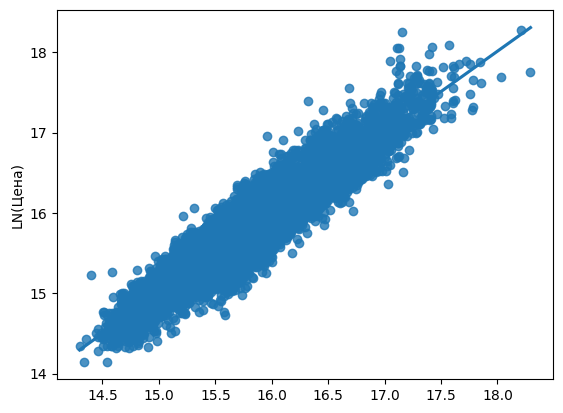

In [36]:
X = sm.add_constant(X_train) # добавляем константу = 1 к факторам

# Построение Robust Regression (RLM - Robust Linear Model)
# M-estimator: HuberT (по умолчанию) - функция потерь, менее чувствительная к выбросам
# Другие: "andrewshat", "bisquare", "hampel", "trimmed", "ramsey"
rlm_model = sm.RLM(Y_train, X, M = sm.robust.norms.HuberT()) # Выбор функции потерь HuberT
rlm_results = rlm_model.fit()
print(rlm_results.summary())

# Строим график
sns.regplot(x = rlm_results.fittedvalues.copy().values, y = Y_train)
plt.show()

In [37]:
d = pd.read_html(rlm_results.summary().tables[1].as_html(), header = 0, index_col = 0)[0]
d['P>|z|'].sort_values(ascending = False)

C:\Users\skapr\AppData\Local\Temp\ipykernel_17632\1266833968.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(rlm_results.summary().tables[1].as_html(), header = 0, index_col = 0)[0]


const                                0.0
Этажность_1^2 Долгота                0.0
ГП^3                                 0.0
Этажность_1 Раст_центр_1 Объем       0.0
Этажность_1 Раст_центр_1^2           0.0
Этажность_1 Широта Объем             0.0
Этажность_1 Долгота Широта           0.0
Этажность_1 Долгота^2                0.0
Этажность_1 Ремонт_бин_enc Широта    0.0
Этажность_1 Ремонт_бин_enc^2         0.0
Этажность_1 ГП Раст_центр_1          0.0
Этажность_1 ГП^2                     0.0
Этажность_1^2 Широта                 0.0
Этажность_1^2 ГП                     0.0
ОПлощадь                             0.0
Этажность_1^3                        0.0
Этаж_4_enc Широта^2                  0.0
Этаж_4_enc Долгота^2                 0.0
Этаж_4_enc Ремонт_бин_enc^2          0.0
Этаж_4_enc^2 Раст_центр_1            0.0
Этаж_4_enc^2 Широта                  0.0
Этаж_4_enc^2 Долгота                 0.0
Этаж_4_enc^2 Ремонт_бин_enc          0.0
Этаж_4_enc^2 ГП                      0.0
Этаж_4_enc^2 Эта

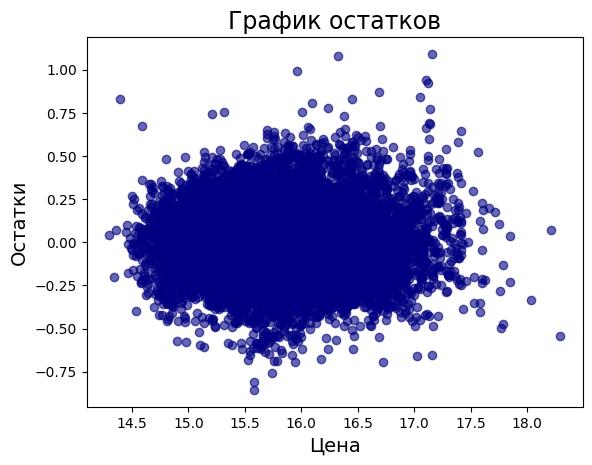

In [38]:
# Строим график остатков обучающей выборки
plt.scatter(x = rlm_results.fittedvalues, y = rlm_results.resid, c = 'navy', alpha = 0.6)
plt.xlabel('Цена', fontsize = 14)
plt.ylabel('Остатки', fontsize = 14)
plt.title('График остатков', fontsize = 17)
plt.show()

C:\Users\skapr\AppData\Local\Temp\ipykernel_17632\477041810.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rlm_results.resid, color = 'navy')


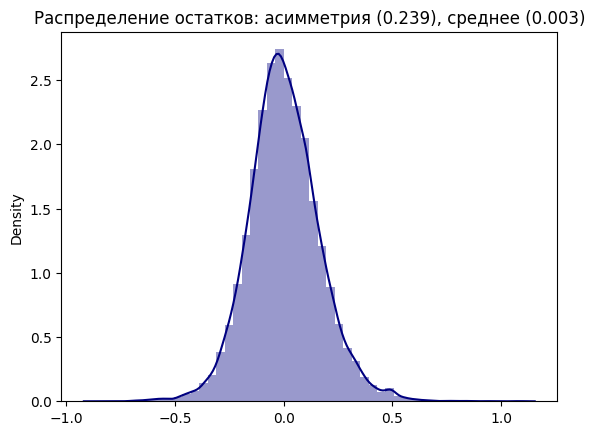

In [39]:
# Строим гистограмму распределения остатков обучающей выборки
resid_mean = round(rlm_results.resid.mean(), 3)
resid_skew = round(rlm_results.resid.skew(), 3)

sns.distplot(rlm_results.resid, color = 'navy')
plt.title(f'Распределение остатков: асимметрия ({resid_skew}), среднее ({resid_mean})', fontsize = 12)
plt.show()

BIC - информационный критерий. Похож на AIC, но имеет более высокий штраф для моделей с большим количеством параметров. Чем меньше значение, тем лучше.

Omnibus - тест на асимметрию и эксцесс остатков. Мы надеемся увидеть значение, близкое к нулю, которое указывало бы на нормальность. The Prob (Omnibus) выполняет статистический тест, показывающий вероятность того, что остатки нормально распределены. Мы надеемся увидеть здесь что-то близкое к 1. В случае если Omnibus относительно низок, а Prob (Omnibus) относительно высок, остатки в целом нормальны, но не идеальны. Подход с линейной регрессией, вероятно, будет лучше, чем случайное угадывание, но, вероятно, хуже нелинейных подходов.

Skew - мера симметрии данных. Мы хотим видеть что-то близкое к нулю, это указывает на то, что остаточное распределение нормально.

Kurtosis - это мера «пиковости» или кривизны данных. Более высокие пики приводят к большему куртозу. Большой куртоз можно интерпретировать как более плотную кластеризацию остатков около нуля, что подразумевает лучшую модель с небольшим количеством выбросов (т.е. чем больше, тем лучше).

Cond. No. - значения больше 20 вызывают подозрения в мультиколлинеарности. Чаще всего сложно пройти данный тест. Чем меньше, тем лучше.

R2 - насколько переменные хорошо объясняют разброс оценок. Максимальное значение – 1. Но при значениях более 0,9 надо крайне внимательно проверить на эффект мультиколлинеарности. Adj. R-squared - это нормированный R2, который используется для сравнения моделей регрессии (как AIC и BIC).

Durbin-Watson - тест на наличие автокорреляции в остатках. В идеале значение должно стремиться к 2 (минимальное значение – 0, максимальное – 4). Значения меньше 0,8 однозначно указывают на циклические колебания в остатках. Эмпирически считается, что статистика лежит в нормальных пределах, если больше 1,5 и меньше 2,5.

Jarque-Bera (JB) - тест на нормальность остатков. Используется на больших наборах данных, более 2000. По своей сути аналогичен Omnibus. Если Prob(JB)>0.05, то считается, что остатки распределены нормально.

MAE на обучении: 1056173.092
RMSE на обучении: 1874918.5316
MAPE на обучении: 0.1257
R2 на обучении: 0.8527
MAE на тесте: 1043795.0879
RMSE на тесте: 1840439.2968
MAPE на тесте: 0.1246
R2 на тесте: 0.8555


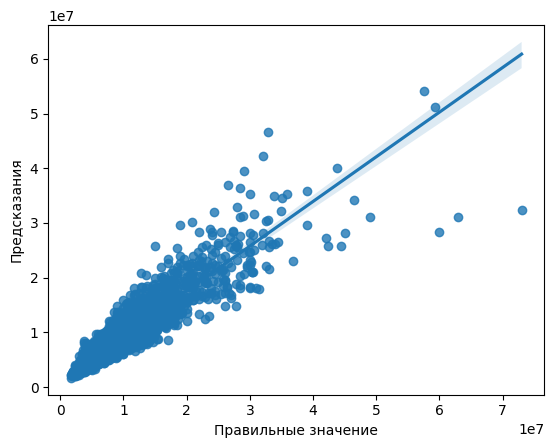

In [40]:
X = sm.add_constant(X)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#pred_1 = np.exp(model2.predict(X))

pred_train = np.exp(rlm_results.predict(X_train))
mse_train = mse(np.exp(Y_train), pred_train)
print("MAE на обучении:", round(mae(np.exp(Y_train), pred_train), 4))
print("RMSE на обучении:", round(sqrt(mse(np.exp(Y_train), pred_train)), 4))
print("MAPE на обучении:", round(mape(np.exp(Y_train), pred_train), 4))
print("R2 на обучении:", round(r2_score(np.exp(Y_train), pred_train), 4))
print("===============================")

pred_test = np.exp(rlm_results.predict(X_test))
mse_test = mse(np.exp(Y_test), pred_test)
print("MAE на тесте:", round(mae(np.exp(Y_test), pred_test), 4))
print("RMSE на тесте:", round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
print("MAPE на тесте:", round(mape(np.exp(Y_test), pred_test), 4))
print("R2 на тесте:", round(r2_score(np.exp(Y_test), pred_test), 4))
print("===============================")

# print("MAE:", round(mae(np.exp(Y), pred_1), 4))
# print("RMSE:", round(sqrt(mse(np.exp(Y), pred_1)), 4))
# print("MAPE:", round(mape(np.exp(Y), pred_1), 4))
# print("R2:", round(r2_score(np.exp(Y), pred_1), 4))

sns.regplot(x = np.exp(Y_test), y = pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

In [ ]:
random_state = [0, 23, 55, 45, 1, 462, 683, 2351, 7432, 5822]

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

for n, rs in enumerate(random_state):
    print('Обработка процесса №', n)

    ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = rs)
    vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = rs)
    kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = rs)
    kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = rs)
    
    combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
    combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])
    
    X_train, X_test = X_poly_selected.loc[combined_train.index], X_poly_selected.loc[combined_test.index]
    Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]
    
    X = sm.add_constant(X_train) # добавляем константу = 1 к факторам
    
    # Строим регрессионную модель
    rlm_model = sm.RLM(Y_train, X, M = sm.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    
    if n == 0:
        coef = pd.DataFrame({f'Коэфф_{n}': rlm_results.params})
    else:
        coef[f'Коэфф_{n}'] = rlm_results.params.values

coef['min'] = abs(coef).min(axis = 1)
coef['max'] = abs(coef).max(axis = 1)
coef['max/min'] = coef['max'] / coef['min']
coef

Обработка процесса № 0
Обработка процесса № 1
Обработка процесса № 2
Обработка процесса № 3
Обработка процесса № 4
Обработка процесса № 5
Обработка процесса № 6


In [ ]:
coef['max/min'].sort_values(ascending = False)

In [41]:
combined_X = pd.concat([X_train, X_test])
combined_X

,const,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,ОПлощадь^2,...,Долгота^2 Объем,Долгота Широта Объем,Долгота Раст_центр_1^2,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Широта Раст_центр_1^2,Раст_центр_1^3,Раст_центр_1^2 Объем
1514,1.0,0.741574,0.508007,1.165252,0.870366,1.477463,0.067656,1.078856,0.398187,0.549932,...,-0.004759,-0.075880,0.010727,0.073117,1.255713,0.463461,-1.209992,0.171055,0.063134,-0.164827
265,1.0,0.335504,0.508007,-1.177657,-1.725466,1.477463,0.067476,1.077414,0.563481,0.112563,...,0.001247,0.019911,0.021424,0.005061,1.250684,0.654100,0.317920,0.342090,0.178911,0.086958
0,1.0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,0.490194,...,-0.004027,-0.070162,0.002470,0.067266,1.274890,-0.234209,-1.222280,0.043026,-0.007904,-0.041251
1451,1.0,-0.141007,-1.968475,-0.626384,0.915907,1.477463,0.062977,1.095186,-0.290614,0.019883,...,0.001086,0.018889,0.005319,0.004724,1.313601,-0.348572,0.328494,0.092496,-0.024544,0.023131
3570,1.0,-0.161724,0.508007,0.200525,0.779284,1.477463,0.064719,1.088466,-1.580382,0.026155,...,0.001147,0.019293,0.161644,0.004854,1.289569,-1.872371,0.324476,2.718562,-3.947177,0.684033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21212,1.0,0.894886,-1.968475,-0.626384,0.551580,-0.676836,-0.323455,0.913700,-0.243063,0.800822,...,-0.102294,0.288962,-0.019110,-0.309215,0.762801,-0.202921,-0.816264,0.053981,-0.014360,-0.057765
18756,1.0,-0.472492,0.508007,-0.626384,0.870366,1.477463,-0.322314,0.914054,0.317368,0.223249,...,0.049569,-0.140573,-0.032464,-0.073381,0.763688,0.265159,0.398654,0.092066,0.031966,0.048059
17082,1.0,0.563401,-1.968475,-1.315475,-3.046152,-0.676836,-0.328274,0.915447,-0.737776,0.317420,...,-0.105365,0.293827,-0.178684,-0.313821,0.767183,-0.618287,-0.819387,0.498290,-0.401581,-0.532197
19660,1.0,-1.487667,-1.968475,-1.177657,-2.135334,-0.676836,-0.324596,0.911352,-0.802858,2.213154,...,-0.120690,0.338855,-0.209228,-0.425906,0.756934,-0.666823,-0.951387,0.587439,-0.517506,-0.738350


In [42]:
combined_X['original_index'] = combined_X.index

combined_X = combined_X.reset_index(drop = True)
combined_X = combined_X.sort_values('original_index').reset_index(drop = True)
combined_X = combined_X.drop('original_index', axis = 1)
combined_X

,const,ОПлощадь,Этаж_4_enc,Этажность_1,ГП,Ремонт_бин_enc,Долгота,Широта,Раст_центр_1,ОПлощадь^2,...,Долгота^2 Объем,Долгота Широта Объем,Долгота Раст_центр_1^2,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Широта Раст_центр_1^2,Раст_центр_1^3,Раст_центр_1^2 Объем
0,1.0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,0.490194,...,-0.004027,-0.070162,0.002470,0.067266,1.274890,-0.234209,-1.222280,0.043026,-0.007904,-0.041251
1,1.0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,0.490194,...,-0.004027,-0.070162,0.002470,0.067266,1.274890,-0.234209,-1.222280,0.043026,-0.007904,-0.041251
2,1.0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,0.490194,...,-0.004027,-0.070162,0.002470,0.067266,1.274890,-0.234209,-1.222280,0.043026,-0.007904,-0.041251
3,1.0,0.700138,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,0.490194,...,-0.004027,-0.070162,0.002470,0.067266,1.274890,-0.234209,-1.222280,0.043026,-0.007904,-0.041251
4,1.0,0.687708,0.508007,1.716525,0.232793,-0.676836,0.062242,1.084320,-0.199199,0.472942,...,-0.004027,-0.070162,0.002470,0.067266,1.274890,-0.234209,-1.222280,0.043026,-0.007904,-0.041251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,1.0,-0.683814,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.467602,...,0.393393,0.533117,-0.000347,-0.515384,-0.747328,-0.018758,0.722469,-0.000471,-0.000012,0.000455
34871,1.0,-0.555364,-1.968475,0.476161,0.870366,1.477463,-0.669481,-0.907638,0.034325,0.308429,...,0.393208,0.533085,-0.000789,-0.515263,-0.747718,0.028277,0.722720,-0.001069,0.000040,0.001034
34872,1.0,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.484757,...,0.393393,0.533117,-0.000347,-0.515384,-0.747328,-0.018758,0.722469,-0.000471,-0.000012,0.000455
34873,1.0,-0.696245,0.508007,1.440889,0.824825,1.477463,-0.669639,-0.907480,-0.022778,0.484757,...,0.393393,0.533117,-0.000347,-0.515384,-0.747328,-0.018758,0.722469,-0.000471,-0.000012,0.000455


In [44]:
pred_1 = np.exp(rlm_results.predict(combined_X))
pred_1

0        7.988211e+06
1        7.988211e+06
2        7.988211e+06
3        7.988211e+06
4        7.957062e+06
             ...     
34870    4.721722e+06
34871    4.818712e+06
34872    4.688183e+06
34873    4.688183e+06
34874    4.699353e+06
Length: 34875, dtype: float64

In [45]:
#Сохраняем в Excel
writer = pd.ExcelWriter('All_прогноз.xlsx')
pd.DataFrame(pred_1).to_excel(writer, 'прогноз')
writer._save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_17632\4109821760.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(pred_1).to_excel(writer, 'прогноз')


# Автоматизация поиска сочетания факторов

In [ ]:
# Выполним подбор регрессоров, при которых будут минимальная мультиколлинеарность и высокая точность
col = [  'ОПлощадь',
         'Этажность_1',
         'ГП',
         'Долгота',
         'Широта',
         'Раст_центр_1',
         #'Объем',
         #'ОПлощадь^2',
         'ОПлощадь Этажность_1',
         'ОПлощадь ГП',
         #'ОПлощадь Долгота',
         #'ОПлощадь Широта',
         #'ОПлощадь Раст_центр_1',
         #'ОПлощадь Объем',
         'Этажность_1^2',
         'Этажность_1 ГП',
         #'Этажность_1 Долгота',
         #'Этажность_1 Широта',
         #'Этажность_1 Раст_центр_1',
         #'Этажность_1 Объем',
         'ГП^2',
         'ГП Долгота',
         #'ГП Широта',
         'ГП Раст_центр_1',
         #'ГП Объем',
         'Долгота^2',
         #'Долгота Широта',
         'Долгота Раст_центр_1',
         'Долгота Объем',
         'Широта^2',
         'Широта Раст_центр_1',
         'Широта Объем',
         'Раст_центр_1^2',
         #'Раст_центр_1 Объем',
         'Объем^2',
         'ОПлощадь^3',
         #'ОПлощадь^2 Этажность_1',
         'ОПлощадь^2 ГП',
         #'ОПлощадь^2 Долгота',
         'ОПлощадь^2 Широта',
         'ОПлощадь^2 Раст_центр_1',
         #'ОПлощадь^2 Объем',
         #'ОПлощадь Этажность_1^2',
         'ОПлощадь Этажность_1 ГП',
         #'ОПлощадь Этажность_1 Долгота',
         #'ОПлощадь Этажность_1 Широта',
         #'ОПлощадь Этажность_1 Раст_центр_1',
         'ОПлощадь Этажность_1 Объем',
         'ОПлощадь ГП^2',
         #'ОПлощадь ГП Долгота',
         #'ОПлощадь ГП Широта',
         #'ОПлощадь ГП Раст_центр_1',
         #'ОПлощадь ГП Объем',
         #'ОПлощадь Долгота^2',
         #'ОПлощадь Долгота Широта',
         #'ОПлощадь Долгота Раст_центр_1',
         'ОПлощадь Долгота Объем',
         #'ОПлощадь Широта^2',
         #'ОПлощадь Широта Раст_центр_1',
         #'ОПлощадь Широта Объем',
         'ОПлощадь Раст_центр_1^2',
         #'ОПлощадь Раст_центр_1 Объем',
         #'ОПлощадь Объем^2',
         'Этажность_1^3',
         'Этажность_1^2 ГП',
         'Этажность_1^2 Долгота',
         'Этажность_1^2 Широта',
         'Этажность_1^2 Раст_центр_1',
         #'Этажность_1^2 Объем',
         'Этажность_1 ГП^2',
         #'Этажность_1 ГП Долгота',
         #'Этажность_1 ГП Широта',
         #'Этажность_1 ГП Раст_центр_1',
         #'Этажность_1 ГП Объем',
         #'Этажность_1 Долгота^2',
         #'Этажность_1 Долгота Широта',
         #'Этажность_1 Долгота Раст_центр_1',
         #'Этажность_1 Долгота Объем',
         #'Этажность_1 Широта^2',
         'Этажность_1 Широта Раст_центр_1',
         'Этажность_1 Широта Объем',
         'Этажность_1 Раст_центр_1^2',
         'Этажность_1 Раст_центр_1 Объем',
         #'Этажность_1 Объем^2',
         'ГП^3',
         #'ГП^2 Долгота',
         #'ГП^2 Широта',
         'ГП^2 Раст_центр_1',
         #'ГП^2 Объем',
         'ГП Долгота^2',
         'ГП Долгота Широта',
         #'ГП Долгота Раст_центр_1',
         #'ГП Долгота Объем',
         #'ГП Широта^2',
         'ГП Широта Раст_центр_1',
         #'ГП Широта Объем',
         'ГП Раст_центр_1^2',
         #'ГП Раст_центр_1 Объем',
         #'ГП Объем^2',
         'Долгота^3',
         #'Долгота^2 Широта',
         'Долгота^2 Раст_центр_1',
         'Долгота^2 Объем',
         #'Долгота Широта^2',
         #'Долгота Широта Раст_центр_1',
         'Долгота Широта Объем',
         #'Долгота Раст_центр_1^2',
         #'Долгота Раст_центр_1 Объем',
         'Долгота Объем^2',
         'Широта^3',
         'Широта^2 Раст_центр_1',
         'Широта^2 Объем',
         #'Широта Раст_центр_1^2',
         #'Широта Раст_центр_1 Объем',
         #'Широта Объем^2',
         'Раст_центр_1^3',
         'Раст_центр_1^2 Объем',
         'Раст_центр_1 Объем^2',
         #'Объем^3',
         'Этаж_4_enc',
         'Ремонт_бин_enc']

res = get_factors(X_scaled_selected, Y_train, col)

In [ ]:
# Выведем список регрессоров лучшей модели
res.loc[0][2] # первый индекс [0] - это строка, второй [2] - это столбец.

# CV

In [199]:
# Делим имеющуюся выборку на обучающую и тестовую
random_state = [3, 23, 58, 34, 0, 456, 789, 777, 1234, 369]

ektb = X_cyti[X_cyti['Город'] == 'Екатеринбург']
vlad = X_cyti[X_cyti['Город'] == 'Владивосток']
kras = X_cyti[X_cyti['Город'] == 'Краснодар']
kazan = X_cyti[X_cyti['Город'] == 'Казань']

all_rmse = [] 
all_mae = []
all_mape = []
all_r2 = []

model_cv = LinearRegression()

for n, rs in enumerate(random_state):
    print('Обработка процесса №', n)

    ektb_train, ektb_test = train_test_split(ektb, test_size = 0.2, random_state = rs)
    vlad_train, vlad_test = train_test_split(vlad, test_size = 0.2, random_state = rs)
    kras_train, kras_test = train_test_split(kras, test_size = 0.2, random_state = rs)
    kazan_train, kazan_test = train_test_split(kazan, test_size = 0.2, random_state = rs)

    combined_test = pd.concat([ektb_test, vlad_test, kras_test, kazan_test])
    combined_train = pd.concat([ektb_train, vlad_train, kras_train, kazan_train])

    X_train, X_test = X_scaled_selected.loc[combined_train.index], X_scaled_selected.loc[combined_test.index]
    Y_train, Y_test = Y.loc[combined_train.index], Y.loc[combined_test.index]

    model_cv.fit(X_train, Y_train)
 
    pred_test = np.exp(model_cv.predict(X_test))
    mse_test = mse(np.exp(Y_test), pred_test)
    
    all_rmse.append(round(sqrt(mse(np.exp(Y_test), pred_test)), 4))
    all_mae.append(round(mae(np.exp(Y_test), pred_test), 4))
    all_mape.append(round(mape(np.exp(Y_test), pred_test), 4))
    all_r2.append(r2_score(np.exp(Y_test), pred_test))

Обработка процесса № 0
Обработка процесса № 1
Обработка процесса № 2
Обработка процесса № 3
Обработка процесса № 4
Обработка процесса № 5
Обработка процесса № 6
Обработка процесса № 7
Обработка процесса № 8
Обработка процесса № 9


In [200]:
# массив оценок по k блокам
print('MAE:', all_mae)
print('RMSE:', all_rmse)
print('MAPE:', all_mape)
print('R2:', all_r2)

MAE: [1064512.2295, 1130540.6191, 1092376.597, 1071249.7105, 1083314.7694, 1087852.025, 1076917.9048, 1101745.6915, 1100206.5801, 1062962.2327]
RMSE: [1794120.2313, 2878537.7212, 1960346.9588, 1787858.0636, 1916989.752, 2015163.4405, 1825568.0578, 1904078.2767, 1998966.3108, 1810427.2136]
MAPE: [0.1286, 0.1305, 0.129, 0.1306, 0.1298, 0.1283, 0.1284, 0.1305, 0.1281, 0.1286]
R2: [0.8574852012854677, 0.6788263356670121, 0.843874044537044, 0.8582982834881648, 0.8496906709639195, 0.8363711301617407, 0.8646216887274845, 0.8495890277469595, 0.841248085615439, 0.8429616321345769]


In [201]:
# среднее значение mae
print(f'MAE_mean: {np.mean(all_mae)}, std: {np.std(all_mae)}')
print(f'RMSE_mean: {np.mean(all_rmse)}, std: {np.std(all_rmse)}')
print(f'MAPE_mean: {np.mean(all_mape)}, std: {np.std(all_mape)}')
print(f'R2_mean: {np.mean(all_r2)}, std: {np.std(all_r2)}')

MAE_mean: 1087167.8359599998, std: 19400.520628398055
RMSE_mean: 1989205.6026299999, std: 306971.23675672564
MAPE_mean: 0.12923999999999997, std: 0.0009541488353501287
R2_mean: 0.8322966100327808, std: 0.05182150071147766


In [ ]:
MAE на тесте: 1065642.0444
RMSE на тесте: 1874726.1227
MAPE на тесте: 0.1272
R2 на тесте: 0.8501

In [120]:
combined_X = pd.concat([X_train, X_test])
combined_X

,ОПлощадь,Этажность_1,ГП,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этажность_1,ОПлощадь ГП,...,Долгота Широта Объем,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Раст_центр_1^3,Раст_центр_1^2 Объем,Раст_центр_1 Объем^2,Этаж_4_enc,Ремонт_бин_enc
1881,-0.762542,1.854343,0.870366,0.064832,1.083378,-0.780215,-0.091446,-0.558270,0.350152,-0.747020,...,0.634102,-0.125420,1.106852,-0.480438,0.406213,-0.343334,-0.536097,-0.594224,0.508007,-0.676836
6886,0.725000,0.889616,0.460498,0.064014,1.087927,-1.235191,-1.039574,0.402404,1.177296,0.735164,...,-0.913149,-1.144171,1.112614,-0.982856,-0.839771,-0.366830,-0.664981,-0.916799,0.508007,-0.676836
6245,0.894886,-0.626384,0.870366,0.062598,1.077369,0.571769,-1.039574,0.553560,-0.122002,0.919077,...,-0.915532,-1.144362,1.099250,1.010925,-0.842133,0.006066,-0.291868,-0.771373,0.508007,1.477463
1603,-1.181043,1.716525,0.870366,0.066362,1.077750,0.293393,-1.442564,-0.711145,-0.170267,-1.167710,...,-1.570826,-1.350976,1.099731,0.703754,-1.371452,-0.113770,-0.529744,-0.915927,-1.968475,1.477463
5543,-0.223878,-0.488566,-0.541402,0.066204,1.100261,0.291796,0.273875,-0.285619,-0.463003,-0.236176,...,1.238721,0.467479,1.128263,0.712554,0.896525,-0.114371,0.105822,0.155717,0.508007,-0.676836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20720,-0.580225,-0.626384,0.779284,-0.323278,0.912857,-0.172616,0.477147,-0.475550,-0.682292,-0.565372,...,0.790443,0.417357,0.894765,0.129964,1.046316,-0.252472,-0.167270,0.074722,0.508007,1.477463
21178,0.865881,-1.177657,-0.131534,-0.325861,0.911107,-1.370660,-0.977740,0.527151,-0.652739,0.856265,...,-1.105546,-1.161469,0.892628,-1.148161,-0.800535,-0.369328,-0.673049,-0.922873,0.508007,-0.676836
12788,-0.534646,0.889616,0.506039,-0.325524,0.915394,-1.036759,0.477147,-0.453342,0.114075,-0.524603,...,0.787183,0.414892,0.897866,-0.791422,1.047905,-0.359954,-0.578100,-0.489866,0.508007,-0.676836
13758,-0.107858,-0.626384,-0.814647,-0.326800,0.923200,0.140907,0.437345,-0.215716,-0.502874,-0.127612,...,0.735605,0.351457,0.907414,0.468820,1.002172,-0.167070,0.045493,0.237747,0.508007,-0.676836


In [121]:
combined_X['original_index'] = combined_X.index

combined_X = combined_X.reset_index(drop = True)
combined_X = combined_X.sort_values('original_index').reset_index(drop = True)
combined_X = combined_X.drop('original_index', axis = 1)
combined_X

,ОПлощадь,Этажность_1,ГП,Долгота,Широта,Раст_центр_1,Объем,ОПлощадь^2,ОПлощадь Этажность_1,ОПлощадь ГП,...,Долгота Широта Объем,Долгота Объем^2,Широта^3,Широта^2 Раст_центр_1,Широта^2 Объем,Раст_центр_1^3,Раст_центр_1^2 Объем,Раст_центр_1 Объем^2,Этаж_4_enc,Ремонт_бин_enc
0,0.700138,1.716525,0.232793,0.062242,1.084320,-0.199199,-1.039574,0.380996,1.893921,0.703047,...,-0.914798,-1.144410,1.108045,0.162188,-0.840578,-0.258350,-0.509035,-0.833421,0.508007,-0.676836
1,0.700138,1.716525,0.232793,0.062242,1.084320,-0.199199,-1.039574,0.380996,1.893921,0.703047,...,-0.914798,-1.144410,1.108045,0.162188,-0.840578,-0.258350,-0.509035,-0.833421,0.508007,-0.676836
2,0.700138,1.716525,0.232793,0.062242,1.084320,-0.199199,-1.039574,0.380996,1.893921,0.703047,...,-0.914798,-1.144410,1.108045,0.162188,-0.840578,-0.258350,-0.509035,-0.833421,0.508007,-0.676836
3,0.700138,1.716525,0.232793,0.062242,1.084320,-0.199199,-1.039574,0.380996,1.893921,0.703047,...,-0.914798,-1.144410,1.108045,0.162188,-0.840578,-0.258350,-0.509035,-0.833421,0.508007,-0.676836
4,0.687708,1.716525,0.232793,0.062242,1.084320,-0.199199,-1.039574,0.370360,1.880281,0.690638,...,-0.914798,-1.144410,1.108045,0.162188,-0.840578,-0.258350,-0.509035,-0.833421,0.508007,-0.676836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34870,-0.683814,1.440889,0.824825,-0.669639,-0.907480,-0.022778,0.877294,-0.523751,0.246278,-0.668641,...,0.032128,0.580095,-0.929111,-0.351732,0.347530,-0.215485,0.041533,0.593166,0.508007,1.477463
34871,-0.555364,0.476161,0.870366,-0.669481,-0.907638,0.034325,0.877294,-0.463512,-0.113259,-0.538758,...,0.032351,0.580333,-0.929237,-0.312030,0.347437,-0.199583,0.090216,0.644344,-1.968475,1.477463
34872,-0.696245,1.440889,0.824825,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,0.233687,-0.681130,...,0.032128,0.580095,-0.929111,-0.351732,0.347530,-0.215485,0.041533,0.593166,0.508007,1.477463
34873,-0.696245,1.440889,0.824825,-0.669639,-0.907480,-0.022778,0.877294,-0.529322,0.233687,-0.681130,...,0.032128,0.580095,-0.929111,-0.351732,0.347530,-0.215485,0.041533,0.593166,0.508007,1.477463


In [122]:
pred_1 = np.exp(model2.predict(combined_X))
pred_1

array([8416861.7667874 , 8416861.7667874 , 8416861.7667874 , ...,
       4746994.61217207, 4746994.61216866, 4757326.90316839])

In [123]:
#Сохраняем в Excel
writer = pd.ExcelWriter('All_прогноз.xlsx')
pd.DataFrame(pred_1).to_excel(writer, 'прогноз')
writer._save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_15356\4109821760.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(pred_1).to_excel(writer, 'прогноз')


# Предсказания и доверительные интервалы

In [ ]:
Предсказания и доверительные интервалы
y_pred = results.predict(X_test)
predictions = results.get_prediction(X_test)
iv_l = predictions.summary_frame()["obs_ci_lower"]  # нижняя граница доверительного интервала для предсказания
iv_u = predictions.summary_frame()["obs_ci_upper"]  # верхняя граница доверительного интервала для предсказания
# Здесь используется obs_ci_lower и obs_ci_upper (obs - observation), так как мы предсказываем интервал для отдельных наблюдений, а не среднее значение.